<a href="https://colab.research.google.com/github/myngoc-trg/BERN04_ANN_DeepLearning/blob/main/Lab_1/BERN04_lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:40px;"><center>Exercise I:<br> Training of simple MLP models
</center></h1>

# Introduction
## Short summary
In this exercise you will:

* train MLPs for simple classification and regression problems.
* learn how hyper-parameters such as learning rate, batch size and number of epochs affect training.

You should write the report of the exercise within this notebook. The details of how to do that can be found below in section "Writing the report".

**Deadline for submitting the report: See Canvas assignment.**

## The data
We will use two synthetic different data sets in this exercise

### syn2
The *syn2* dataset represents a binary classification problem. The input data is 2D which allows for an easy visual inspection of the different classes and the decision boundary implemented by the network. The dataset is generated using random numbers each time you run the cell. This means that each time you generate the data it will be slightly different. You can control this by having a fixed *seed* to the random number generator. The cell "PlotData" will plot the *syn2* dataset.

### regr1
The *regr1* dataset represents a regression problem. It has one input and one target variable. It a cosine function, with the possibility to add some noise and dampening on the output. Again see the cell "PlotData" to look at the dataset.

## The exercises
There are 8 questions in this exercise. These 8 questions can be found in three different cells below (see section "The Different Cells"). The first 6 questions will use the *regr1* dataset and questions 7-8 will use *syn2*.

## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells.

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 2  | Init | Needed | Sets up the environment|
| 3  | Data | Needed | Defines the functions to generate the artificial datasets |
| 4  | PlotData | Information | Plots the 2D classification datasets |
| 5  | MLP | Needed | Defines the MLP model |
| 6  | Training | Needed | Functions for training and testing the MLP model |
| 7  | Boundary | Needed | Functions for showing classification boundaries and errors |
| 8  | Ex1 | Exercise | For question 1-4 |
| 9  | Ex2 | Exercise | For question 5-6 |
| 10 | Ex3 | Exercise | For question 7-8 |

To start with the exercise you need to run all cells with the celltype "Needed". The very first time we suggest that you enter each of the needed cells, read the cell instruction and run the cell. It is important that you do this in the correct order, starting from the top and work your way down the cells. Later, when you have started to work with the notebook it may be easier to use the command "Run All" or "Run all above" found in the "Cell" dropdown menu.

## Writing the report
The report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a short introduction to the content and purpose of the exercise.
* Answers to questions: For each of the questions provide an answer. It can be short answers or longer ones depending on the nature of the questions, but try to be efficient in your writing. (Don't include lots of program output or plots that aren't central to answering the question.)
* Conclusion: Summarize your findings in a few sentences.

It is important that you write the report in this last cell and **not** after each question!

## Last but not least
Have fun!

---

# CellName: Init (#2)
**CellType: Needed**  
**Cell instruction:**

In the cell below, we will import needed libraries.

Run the cell by entering into the cell and press "CTRL Enter".

In [1]:
import torch
device = 'cpu'
# Uncomment this to use CUDA acceleration if available
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"PyTorch: Using {device} device")
# The floating point data type can be changed here
dtype_torch = torch.float32

from torch.utils.data import DataLoader, TensorDataset
from torch import nn, Tensor
from collections import OrderedDict
!pip install torchmetrics
import torchmetrics

import matplotlib.pyplot as plt
import numpy as np

PyTorch: Using cpu device
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.7 MB/s eta 0:00:00


# CellName: Data (#3)
**CellType: Needed**  
**Cell instruction:**

This cell defines the two synthetic datasets. The last function is used for standardization of the data.

Run the cell by entering into the cell and press "CTRL Enter".

In [2]:
def syn2(N):
    "Generate data for a classification problem in 2D."
    x = np.empty(shape=(N, 2))
    d = np.empty(shape=(N, 1))
    N1 = N // 2

    # Positive samples
    x[:N1,:] = 0.8 + np.random.normal(size=(N1, 2))
    # Negative samples
    x[N1:,:] = -.8 + np.random.normal(size=(N-N1, 2))

    # Target
    d[:N1] = 1
    d[N1:] = 0

    return x, d

def regr1(N, periods=2, damp=False, v=0):
    "Generate data for 1D regression problem with damped cosine and noise"
    dx = 2*periods*np.pi / (N-1)
    x = np.arange(N) * dx

    if damp:
        d = np.cos(x)*np.exp(-x*0.05)
    else:
        d = np.cos(x)
    noise = lambda n : np.random.normal(size=n)
    std_signal = np.std(d)
    d = d + v * std_signal * noise(N)

    return x[:, None], d[:, None]

def standard(x):
    "Mean and stddev across samples"
    return np.mean(x, axis=0), np.std(x, axis=0)

# CellName: PlotData (#4)
**CellType: Information**  
**Cell instruction:**

Here, we generate 100 cases for *syn2* and *regr1* datasets and plot them.

Run the cell by entering into the cell and press "CTRL Enter".

**Note!** This cell is not needed for the actual exercises, it is just to visualize the two datasets.

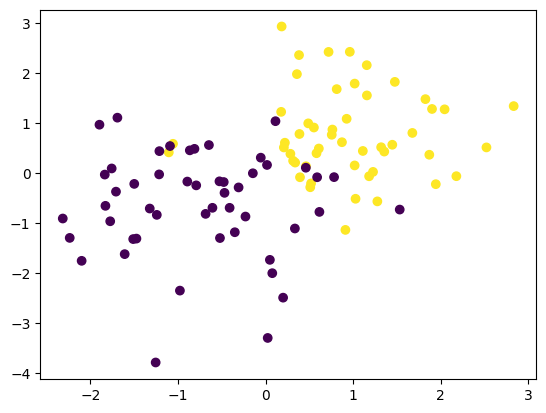

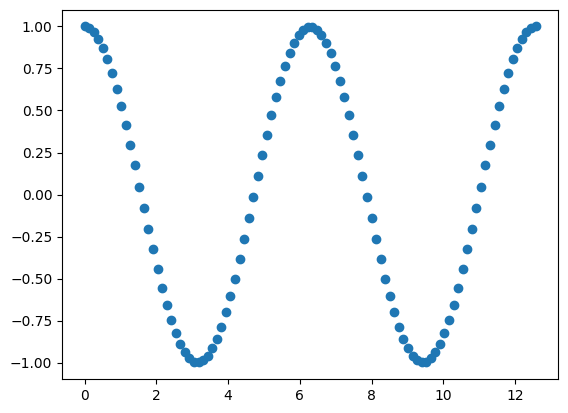

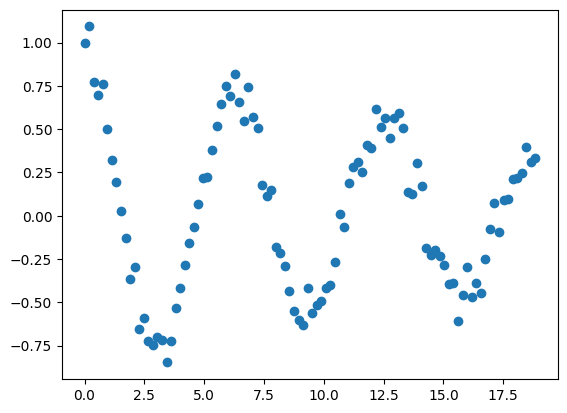

In [3]:
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

x, d = syn2(100)
plt.figure()
plt.scatter(x[:,0], x[:,1], c=d)

# Regression, one period, no noise
x, d = regr1(100, 2, False, 0)
plt.figure()
plt.scatter(x, d)

# Regression, 1.5 period, exponential damping, some noise
x, d = regr1(100, 3, True, 0.2)
plt.figure()
plt.scatter(x, d)

# CellName: MLP (#5)
**CellType: Needed**  
**Cell instruction:**

This cell defines the MLP model. Several MLP hyperparameters are needed to define a model.
Here is a list of them:  
(**Note:** They can all be specified when you call
this function in later cells. The ones specified in this cell are the default values.)

* inputs: the input dimension (integer)

* output: the input dimension (integer)

* nodes: size of the network, eg `[5]` for a one hidden layer with 5 nodes and `[5, 3]` for a two layer network with 5 and 3 hidden nodes each.

* activation: the activation function. Most common are
    * `nn.ReLU`
    * `nn.Tanh`
        
* output_activation: the activation function for the output nodes. Most common are
    * `None` (linear activation)
    * `nn.Sigmoid`
    * `nn.Softmax`
      
Run the cell by entering into the cell and press "CTRL Enter".

In [4]:
class Network(nn.Module):
    "A simple MLP with one or more fully connected layers"

    def __init__(self, *, inputs=1, outputs=1, nodes=[4], activation=nn.Tanh, out_activation=None):
        """
        Args:
            inputs (int, optional): The number of input nodes.
            outputs (int, optional): The number of output nodes.
            nodes (list, optional): A list of layer sizes.
            activation: Activation function (or None for linear). Defaults to nn.Tanh
            out_activation (optional): Activation function for output layer.
        """
        super().__init__()

        seqstack = OrderedDict()
        prevn = inputs
        for i, n in enumerate(nodes):
            seqstack[f"layer{i+1}"] = nn.Linear(prevn, n, dtype=dtype_torch)
            prevn = n
            if activation is not None:
                seqstack[f"act{i+1}"] = activation()
        seqstack["layerN"] = nn.Linear(prevn, outputs, dtype=dtype_torch)
        if out_activation is not None:
            seqstack["actN"] = out_activation()
        self.mlp_stack = nn.Sequential(seqstack)

    def forward(self, x : Tensor):
        "Apply the network stack on some input"
        return self.mlp_stack(x)

    def predict(self, input_data):
        """
        Apply the network on a set of input data.

        Args:
            input_data (np.ndarray): Input data

        Returns:
            pred (np.ndarray): Predicted output.
        """
        self.eval()
        inp = torch.tensor(input_data, dtype=dtype_torch, device=device)
        with torch.no_grad():
            pred = self(inp)
        return pred.cpu().numpy()

    def __str__(self):
        s = super().__str__()
        ps = ["Named parameters:"] + [
            f"{name}: {param.numel()}" for name, param in
             self.mlp_stack.named_parameters() if param.requires_grad]
        totp = sum(p.numel() for p in self.mlp_stack.parameters() if p.requires_grad)
        return s + f"\nTrainable parameters: {totp}\n" + "\n  ".join(ps) + "\n"

# CellName: Training (#6)
**CellType: Needed**  
**Cell Instruction:**

This cell defines functions for training the model for a single epoch (`train_epoch`),
evaluating the performance in the validation data (`test`) and training and validating over
many epochs (`train_loop`). Finally, it defines a function (`plot_training`) for plotting
the training progress.

The `train_loop` function takes a previously defined `Network` model, two PyTorch `DataLoader`s
that provide the data for training and test, and several hyperparameters:

* loss_fn: The error function used during training. There are three common ones
    * `nn.MSELoss` (mean squared error)
    * `nn.BCELoss` (binary cross entropy)
    * `nn.CrossEntropyLoss` (categorical cross entropy)

* optimizer: The error minimization method, which is constructed with information about the model and a learning rate. Common choices are
    * `torch.optim.SGD`
    * `torch.optim.Adam`

* metrics: Additional metrics to compute and print besides the loss. We use the [torcheval.metrics package](https://docs.pytorch.org/torcheval/main/torcheval.metrics.html) and pass the metric(s) as a dict with `{name: metric}`. Examples:
    * `{'accuracy': ptmetrics.BinaryAccuracy()}`
    * `{'MSE': ptmetrics.MeanSquaredError()}`

Run the cell by entering into the cell and press "CTRL Enter".

In [5]:
def train_epoch(*, model : Network, dataloader : DataLoader,
                loss_fn, optimizer : torch.optim.Optimizer):
    """
    Train a model for a single epoch.

    Args:
        model (Network): The network.
        dataloader (DataLoader): Batch DataLoader with training data.
        loss_fn (Loss): Loss function, e.g. nn.MSELoss.
        optimizer (Optimizer): The optimizer used to update the network.

    Returns:
        train_loss (float): Training error over all batches.
    """
    model.train()
    train_loss = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)   # Move data to GPU if necessary
        optimizer.zero_grad()   # Reset the gradients

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item() * len(X)

        # Backpropagation
        loss.backward()
        optimizer.step()
    return train_loss / len(dataloader.dataset)

def test(*, model : Network, dataloader : DataLoader, loss_fn, metrics=[]):
    """
    Test a model on a set of data.

    Args:
        model (Network): The network.
        dataloader (DataLoader): DataLoader with data to test.
        loss_fn (Loss): Loss function, e.g. nn.MSELoss.
        metrics (iterable): Additional metrics from torchmetrics.

    Returns:
        loss (float): Mean error over all batches.
    """
    model.eval()
    loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item() * len(X)
            for m in metrics:
                m.update(pred, y)
    return loss / len(dataloader.dataset)


def train_loop(*, model : Network, train_dataloader : DataLoader,
               val_dataloader : DataLoader = None, loss_fn,
               optimizer : torch.optim.Optimizer, epochs : int,
               print_every:int = 100, metrics=None, print_final=True):
    """
    Train and optionally test a model.

    Args:
        model (Network): The network.
        train_dataloader (DataLoader): Training data.
        val_dataloader (DataLoader, optional): Validation data.
        loss_fn (Loss): Loss function, e.g. nn.MSELoss.
        optimizer (Optimizer): An optimizer from torch.optim.
        epochs (int): Number of epochs to train for.
        print_every (int, optional): Print loss every so many epochs. Defaults to 100.
        metrics (dict(name: metric), optional): Record/print these additional metrics.
        print_final(bool, optional): Print final metrics. Defaults to True.

    Returns:
        train_losses (list(float)): Training loss during each epoch.
        val_losses (list(float)): Validation loss after each epoch.
        metrics_res (dict(name: list(float))): Values of metrics after each epoch.
    """
    train_losses = []
    val_losses = []
    val_loss = np.nan

    # Move metrics to CPU/GPU and prepare for their output
    metrics = {name: m.to(device) for name, m in (metrics or {}).items()}
    metrics_res = {name: [] for name in metrics.keys()}

    for t in range(epochs):
        train_loss = train_epoch(model=model, dataloader=train_dataloader,
                           loss_fn=loss_fn, optimizer=optimizer)
        train_losses.append(train_loss)
        if val_dataloader is not None:
            for m in metrics.values():
                m.reset()
            val_loss = test(dataloader=val_dataloader, model=model,
                            loss_fn=loss_fn, metrics=metrics.values())
            val_losses.append(val_loss)
            for name, m in metrics.items():
                metrics_res[name].append(m.compute().cpu())
        if (print_every > 0 and t % print_every == 0) or (
                print_every >= 0 and t + 1 == epochs):
            extras = [f" {n} {v[-1]:<7f}" if torch.isreal(v[-1])
                      else f" {n} {v[-1]}"
                      for n, v in metrics_res.items()]
            print(f"Epoch {t+1:<7d} train {train_loss:<7f} "
                  f" validation {val_loss:<7f}", "".join(extras))
    if print_final:
        print("\n** Validation metrics after training **\n"
              f"Loss {val_losses[-1]:<7g}")
        for n, v in metrics_res.items():
            if torch.isreal(v[-1]):
                print(f"{n} {v[-1]:<7g}")
            else:
                print(f"{n}:")
                print(v[-1])
        print()
    return train_losses, val_losses, metrics_res

def plot_training(train_loss, val_loss, metrics_res={}):
    "Plot the training history"
    plt.figure()
    plt.ylabel('Loss / Metric')
    plt.xlabel('Epoch')
    plt.plot(train_loss, label="Training loss")
    plt.plot(val_loss, label="Validation loss")
    for name, res in metrics_res.items():
        if torch.isreal(res[0]):
            plt.plot(res, label=name)
    plt.legend(loc='best')
    plt.show()

# CellName: Boundary (#7)
**CellType: Needed**  
**Cell Instruction:**

This cell defines a function for presenting the output of binary MLP classifiers, plotting the decision boundary for a problem with 2D input. In brief, this function defines a grid that covers the input data. Each grid point is then used as an input to the trained MLP and to compute an output. If the output is close to 0.5 it is marked as the boundary.

Run the cell by entering into the cell and press "CTRL Enter".

In [6]:
def decision_boundary(X : np.ndarray, Y1 : np.ndarray, model):
    """
        Plot classfication and decision boundary for binary classification problem

        Args:
            X (np.ndarray): input
            Y1 (np.ndarray): target
            model (Network): the model

        Returns:
            None.
    """
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # grid stepsize
    h = 0.025

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    Z[Z > .5] = 1
    Z[Z <= .5] = 0

    Y_pr = model.predict(X).flatten()
    Y = Y1.flatten()

    Y_pr[Y_pr > .5] = 1
    Y_pr[Y_pr <= .5] = 0
    Y[(Y != Y_pr) & (Y == 0)] = 2
    Y[(Y != Y_pr) & (Y == 1)] = 3

    plt.figure()
    #plt.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha = .9)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

    plt.scatter(X[Y == 1, 0], X[Y == 1, 1], marker='+', c='k')
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], marker='o', c='k')

    plt.scatter(X[Y == 3, 0], X[Y == 3, 1], marker = '+', c='r')
    plt.scatter(X[Y == 2, 0], X[Y == 2, 1], marker = 'o', c='r')

    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.show()

---
End of "Needed" and "Information" cells. Below are the cells for the actual exercise.

---

# CellName: Ex1 (#8)
**CellType: Exercise**  
**Cell instruction:**

Questions 1-4 look at three essential parameters that controls the training process of an MLP: the *learning rate*, *batch size* and *number of epochs* (or epochs for short). By training process we mean here the minimization of the given loss function. The task is to train an MLP with four hidden nodes that can fit the *regr1* dataset. In this version of the dataset, there is no noise. Therefore, we need not specify any seed.

The dataset and network have been selected so that it is possible, but not trivial, to get a good training result.
A successful training means here when the networks has reached a loss < 0.01, and visually have fitted the data accurately. In this exercise we do not care about possible overfitting, only about the minimization of the loss function, we therefore do not have a validation dataset.

## Question 1, variations in pre-defined MLP
For the first question you can simply run the cell below. It will load 50 samples from the *regr1* dataset (no noise added). The network has 4 hidden nodes in a single hidden layer, *tanh* activation function, linear output activation function, *stochastic gradient descent* as minimization method, MSE loss function, and a learning rate of 0.05.
It will train for 4000 epochs using a batchsize of 50, meaning that we efficiently are using ordinary gradient descent learning. Run this cell five times. **(a) Do you see the same loss vs epoch behavior each time your run?** If not, **why?** **(b) Do you observe that training fails, i.e. do not reach low loss, during any of these five runs?**

## Question 2, vary learning rate
You will now study what happens when you train with different learning rates. Test at least 5 different learning rates in the range from 0.001 to 0.5. For each learning rate train the network three times and record the average MSE value over these three runs. **Present your average MSE results and discuss your findings**.

**Note:** You should keep the same settings as for Q1, only vary the learning rate. The learning rate is best investigated with (roughly) proportional changes rather than constant steps: For example, trying 0.5, 0.2, 0.1, 0.05, 0.02 etc. typically gives more interesting results than 0.5, 0.4, 0.3, 0.2, 0.1.

## Question 3, vary (mini)batch size
We now (hopefully) have discovered that the learning rate influences the efficiency of the loss minimization. We will now look at what happens when we use *stochastic gradient descent*, meaning that we will have a "batch size" that is smaller the the size of the training data. (We now adapt to the language of ANN packages such as PyTorch and use the word "batch" where most literature would use "mini-batch".) Use a fixed learning rate of 0.05, but test different batch sizes in the range 1 to 50. Train three different networks for each batch size, but this time record if the training was successful (i.e. MSE < 0.01) and approximately after how many epochs the good solution was found. **Present and discuss your findings**.

**Note:** The batch size should (fairly well) divide the total data size. With a data size of 50, good batch sizes are 50, 25, 13, 10, 5... Sizes that fit poorly, like 40, create a small last batch which could give you the disadvantages of both small and large batch sizes at the same time.

## Question 4, select good hyper-parameters
Find a combination of learning rate and batch size that gives a good solution within 1000 epochs. We always have to remember that two runs with identical hyper parameters (e.g. learning rate, batch size etc) will result in different final results. Your set of parameters should *most* of the times result in a good solution within 1000 epochs. **Present your best combination of learning rate and batch size, and its result**.

Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.956335  validation 0.805501  MSE 0.805501
Epoch 101     train 0.501565  validation 0.501537  MSE 0.501537
Epoch 201     train 0.498815  validation 0.498787  MSE 0.498787
Epoch 301     train 0.496134  validation 0.496108  MSE 0.496108
Epoch 401     train 0.493543  validation 0.493518  MSE 0.493518
Epoch 501     train 0.491058  validation 0.491033  MSE 0.491033
Epoch 601     train 0.488666  validation 0.488643  MSE 0.488643
Epoch 701     train 0.486332  validation 0.486309  MSE 0.486309
Epoch 801     train 0.484004  validation 0.483981  MSE 0.483981
Epoch 901     train 0.481625  validation 0.481601  MSE 0.481601
Epoch 1001    train 0.479143  validation 0.479118  MSE 0.

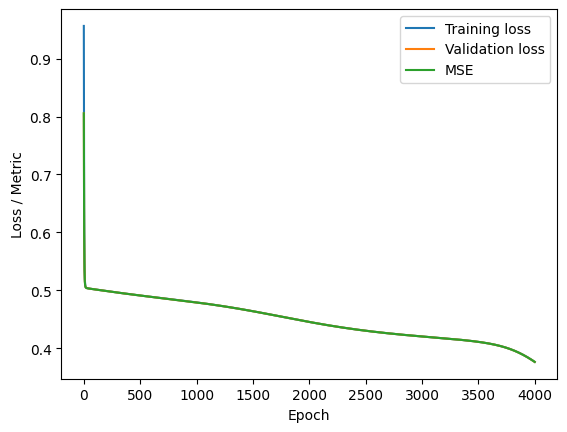

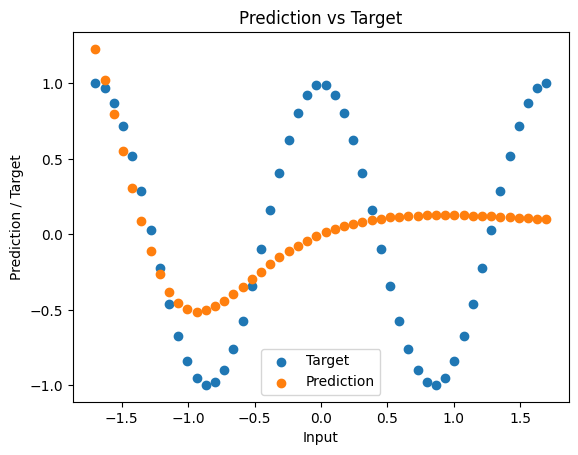

CPU times: user 9.58 s, sys: 39.4 ms, total: 9.62 s
Wall time: 12.2 s


In [ ]:
%%time

# Generate training data
x_trn, d_trn = regr1(50, 2, 0, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std

# Define the network, cost function and training settings
model_ex1 = Network(
    inputs=1,            # number of input nodes
    outputs=1,           # number of output nodes
    nodes=[4],           # number of nodes in hidden layer
    activation=nn.Tanh,  # activation function in hidden layer
    out_activation=None  # activation function in output layer (if not linear)
    ).to(device)         # move data to GPU or keep with CPU

# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
learning_rate = 0.05          # learning rate
loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 4000
minibatch_size = 50

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Set up the optimizer
optimizer = opt_method(model_ex1.parameters(), lr=learning_rate)

# Print a summary of the model
print(model_ex1)

# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex1,
    train_dataloader=dl_trn,
    val_dataloader=dl_trn, # Test with the training data
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=100,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Predict output on the training data
d_pred = model_ex1.predict(x_trn)

# Plot the result
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()

## Question 1, variations in pre-defined MLP
For the first question you can simply run the cell below. It will load 50 samples from the *regr1* dataset (no noise added). The network has 4 hidden nodes in a single hidden layer, *tanh* activation function, linear output activation function, *stochastic gradient descent* as minimization method, MSE loss function, and a learning rate of 0.05.
It will train for 4000 epochs using a batchsize of 50, meaning that we efficiently are using ordinary gradient descent learning. Run this cell five times. **(a) Do you see the same loss vs epoch behavior each time your run?** If not, **why?** **(b) Do you observe that training fails, i.e. do not reach low loss, during any of these five runs?**

** (a)
Loss 0.00263663
MSE 0.00263663



** Validation metrics after training **
Loss 0.35525
MSE 0.35525

** Validation metrics after training **
Loss 0.0448664
MSE 0.0448664

** Validation metrics after training **
Loss 0.00244652
MSE 0.00244652

** Validation metrics after training **
Loss 0.00354812
MSE 0.00354812

all five times, loss decreseas the more epoch was run.
we initialize a new model everytime so it always depends on the initial guess of the weights. if lucky then we can get to the global minimum of the loss. If a stupid initialized value of weights, stuck in local minima or never converges.

(b) Yes. The training loss always reduces but for some model then training loss decreases very slow.

## Question 2, vary learning rate
You will now study what happens when you train with different learning rates. Test at least 5 different learning rates in the range from 0.001 to 0.5. For each learning rate train the network three times and record the average MSE value over these three runs. **Present your average MSE results and discuss your findings**.

In [ ]:
# Modify plot_training function for my use

def plot_training(train_loss, val_loss, metrics_res={}, ax=None):
    '''Plot the training history

    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, creates a new figure.
    '''
    if ax is None:
      fig, ax = plt.subplots()

    #plt.figure()
    ax.set_ylabel('Loss / Metric')
    ax.set_xlabel('Epoch')
    ax.plot(train_loss, label="Training loss")
    ax.plot(val_loss, label="Validation loss")
    for name, res in metrics_res.items():
        if torch.isreal(res[0]):
            ax.plot(res, label=name) # Changed plt.plot to ax.plot
    ax.legend(loc='best')
    if ax is None:
      plt.show()


--- Training with Learning Rate: 0.001 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.658759  validation 0.657714  MSE 0.657714
Epoch 101     train 0.583714  validation 0.583200  MSE 0.583200
Epoch 201     train 0.546673  validation 0.546418  MSE 0.546418
Epoch 301     train 0.528165  validation 0.528036  MSE 0.528036
Epoch 401     train 0.518755  validation 0.518688  MSE 0.518688
Epoch 501     train 0.513848  validation 0.513813  MSE 0.513813
Epoch 601     train 0.511195  validation 0.511176  MSE 0.511176
Epoch 701     train 0.509690  validation 0.509678  MSE 0.509678
Epoch 801     train 0.508779  validation 0.508772  MSE 0.508772
Epoch 901     train 0.508185  validation 0.508180  MSE 0.508180
Epoch 1001   

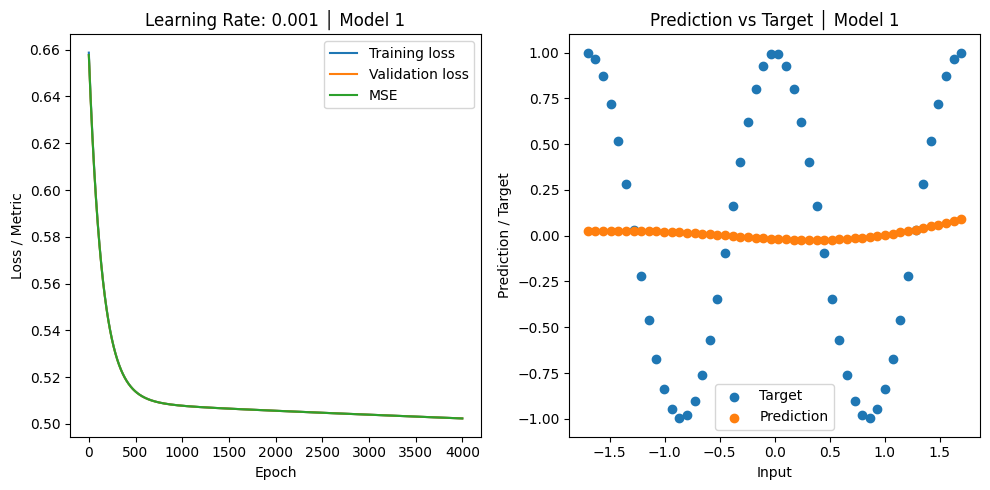


--- Training with Learning Rate: 0.001 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.514926  validation 0.514911  MSE 0.514911
Epoch 101     train 0.513672  validation 0.513662  MSE 0.513662
Epoch 201     train 0.512823  validation 0.512816  MSE 0.512816
Epoch 301     train 0.512207  validation 0.512201  MSE 0.512201
Epoch 401     train 0.511737  validation 0.511732  MSE 0.511732
Epoch 501     train 0.511366  validation 0.511362  MSE 0.511362
Epoch 601     train 0.511066  validation 0.511064  MSE 0.511064
Epoch 701     train 0.510822  validation 0.510819  MSE 0.510819
Epoch 801     train 0.510620  validation 0.510618  MSE 0.510618
Epoch 901     train 0.510453  validation 0.510452  MSE 0.510452
Epoch 1001   

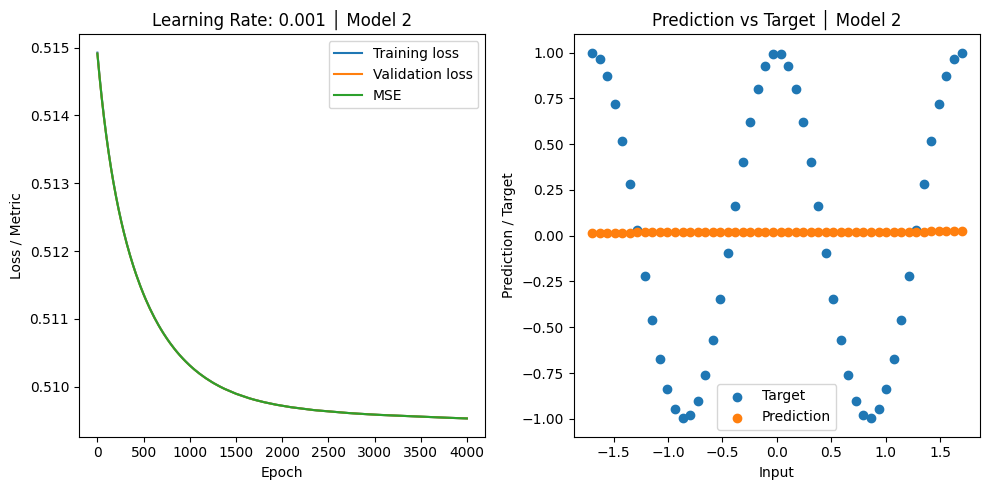


--- Training with Learning Rate: 0.001 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.522898  validation 0.522892  MSE 0.522892
Epoch 101     train 0.522361  validation 0.522356  MSE 0.522356
Epoch 201     train 0.521990  validation 0.521987  MSE 0.521987
Epoch 301     train 0.521701  validation 0.521699  MSE 0.521699
Epoch 401     train 0.521454  validation 0.521452  MSE 0.521452
Epoch 501     train 0.521229  validation 0.521227  MSE 0.521227
Epoch 601     train 0.521016  validation 0.521014  MSE 0.521014
Epoch 701     train 0.520812  validation 0.520810  MSE 0.520810
Epoch 801     train 0.520613  validation 0.520611  MSE 0.520611
Epoch 901     train 0.520419  validation 0.520417  MSE 0.520417
Epoch 1001   

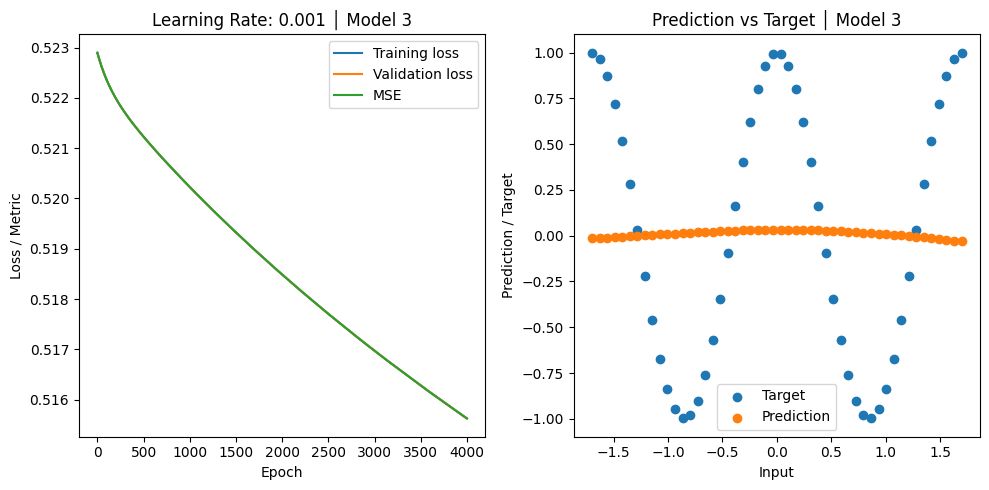


--- Training with Learning Rate: 0.005 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.603774  validation 0.601146  MSE 0.601146
Epoch 101     train 0.516424  validation 0.516267  MSE 0.516267
Epoch 201     train 0.510765  validation 0.510751  MSE 0.510751
Epoch 301     train 0.510039  validation 0.510035  MSE 0.510035
Epoch 401     train 0.509652  validation 0.509648  MSE 0.509648
Epoch 501     train 0.509301  validation 0.509297  MSE 0.509297
Epoch 601     train 0.508963  validation 0.508960  MSE 0.508960
Epoch 701     train 0.508635  validation 0.508632  MSE 0.508632
Epoch 801     train 0.508317  validation 0.508314  MSE 0.508314
Epoch 901     train 0.508007  validation 0.508004  MSE 0.508004
Epoch 1001   

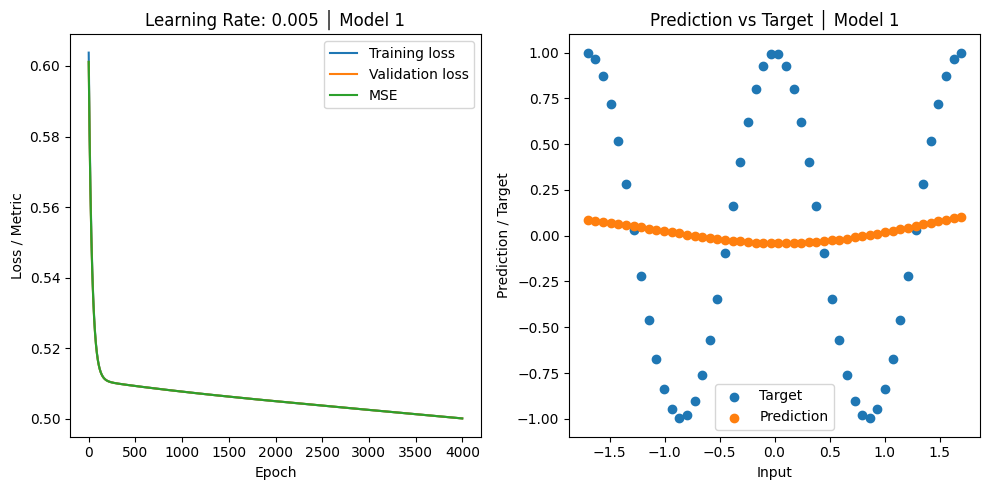


--- Training with Learning Rate: 0.005 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 1.162793  validation 1.142339  MSE 1.142339
Epoch 101     train 0.538905  validation 0.537927  MSE 0.537927
Epoch 201     train 0.505786  validation 0.505724  MSE 0.505724
Epoch 301     train 0.503304  validation 0.503295  MSE 0.503295
Epoch 401     train 0.502629  validation 0.502623  MSE 0.502623
Epoch 501     train 0.502058  validation 0.502052  MSE 0.502052
Epoch 601     train 0.501489  validation 0.501484  MSE 0.501484
Epoch 701     train 0.500918  validation 0.500912  MSE 0.500912
Epoch 801     train 0.500342  validation 0.500336  MSE 0.500336
Epoch 901     train 0.499762  validation 0.499757  MSE 0.499757
Epoch 1001   

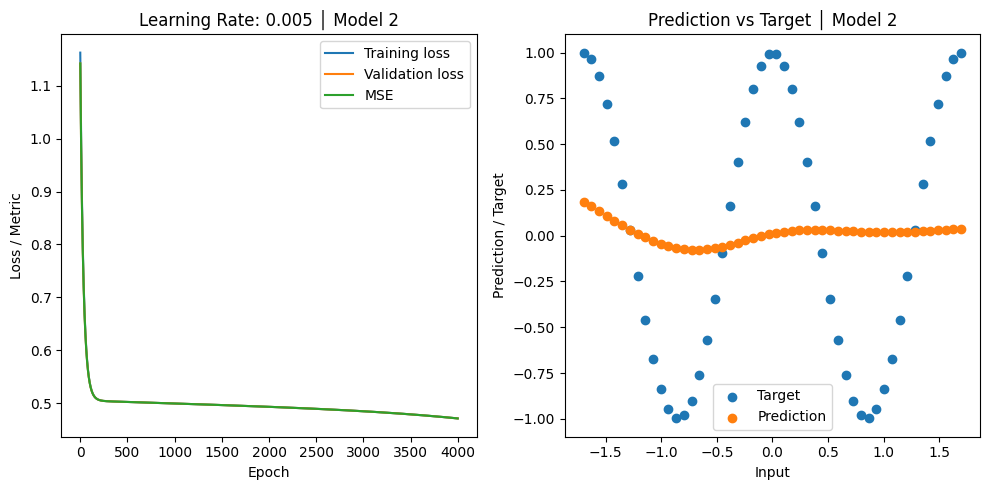


--- Training with Learning Rate: 0.005 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.630715  validation 0.626505  MSE 0.626505
Epoch 101     train 0.518429  validation 0.518314  MSE 0.518314
Epoch 201     train 0.514407  validation 0.514392  MSE 0.514392
Epoch 301     train 0.513318  validation 0.513309  MSE 0.513309
Epoch 401     train 0.512557  validation 0.512551  MSE 0.512551
Epoch 501     train 0.511981  validation 0.511976  MSE 0.511976
Epoch 601     train 0.511532  validation 0.511528  MSE 0.511528
Epoch 701     train 0.511176  validation 0.511173  MSE 0.511173
Epoch 801     train 0.510888  validation 0.510886  MSE 0.510886
Epoch 901     train 0.510653  validation 0.510650  MSE 0.510650
Epoch 1001   

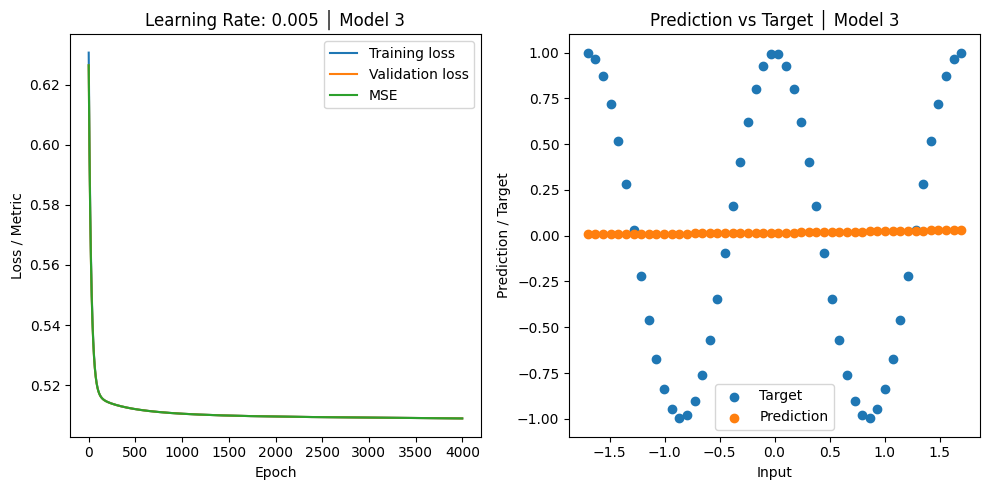


--- Training with Learning Rate: 0.01 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.612496  validation 0.608087  MSE 0.608087
Epoch 101     train 0.522912  validation 0.522816  MSE 0.522816
Epoch 201     train 0.518535  validation 0.518513  MSE 0.518513
Epoch 301     train 0.516666  validation 0.516649  MSE 0.516649
Epoch 401     train 0.515066  validation 0.515050  MSE 0.515050
Epoch 501     train 0.513592  validation 0.513578  MSE 0.513578
Epoch 601     train 0.512224  validation 0.512211  MSE 0.512211
Epoch 701     train 0.510949  validation 0.510937  MSE 0.510937
Epoch 801     train 0.509758  validation 0.509746  MSE 0.509746
Epoch 901     train 0.508643  validation 0.508632  MSE 0.508632
Epoch 1001    

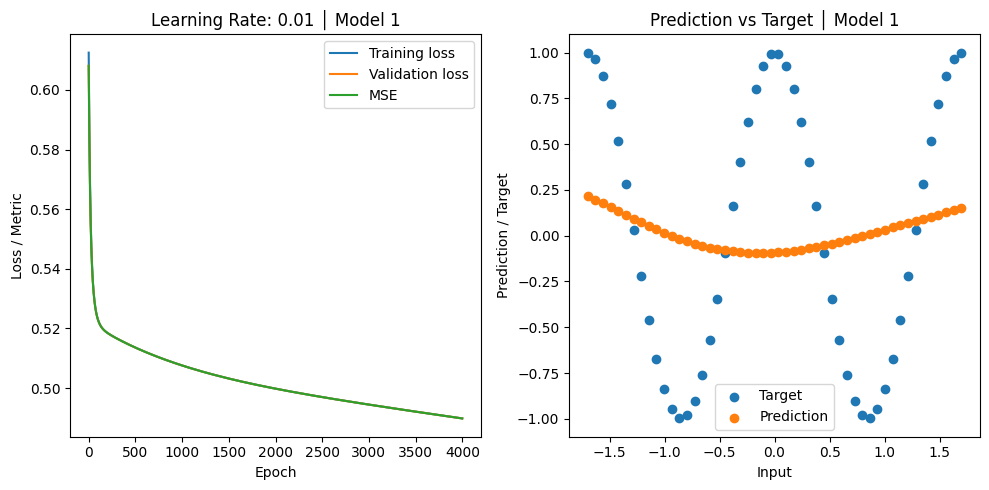


--- Training with Learning Rate: 0.01 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.538949  validation 0.538258  MSE 0.538258
Epoch 101     train 0.512668  validation 0.512602  MSE 0.512602
Epoch 201     train 0.509823  validation 0.509812  MSE 0.509812
Epoch 301     train 0.509076  validation 0.509070  MSE 0.509070
Epoch 401     train 0.508525  validation 0.508520  MSE 0.508520
Epoch 501     train 0.508004  validation 0.507999  MSE 0.507999
Epoch 601     train 0.507493  validation 0.507487  MSE 0.507487
Epoch 701     train 0.506986  validation 0.506981  MSE 0.506981
Epoch 801     train 0.506482  validation 0.506477  MSE 0.506477
Epoch 901     train 0.505976  validation 0.505970  MSE 0.505970
Epoch 1001    

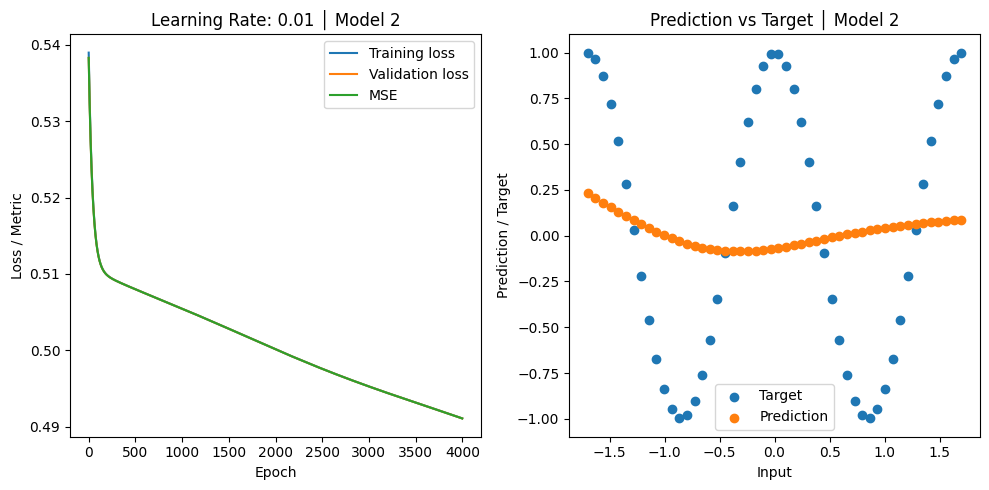


--- Training with Learning Rate: 0.01 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 1.187920  validation 1.146185  MSE 1.146185
Epoch 101     train 0.508674  validation 0.508503  MSE 0.508503
Epoch 201     train 0.504381  validation 0.504371  MSE 0.504371
Epoch 301     train 0.503501  validation 0.503493  MSE 0.503493
Epoch 401     train 0.502647  validation 0.502638  MSE 0.502638
Epoch 501     train 0.501790  validation 0.501781  MSE 0.501781
Epoch 601     train 0.500934  validation 0.500926  MSE 0.500926
Epoch 701     train 0.500086  validation 0.500077  MSE 0.500077
Epoch 801     train 0.499249  validation 0.499240  MSE 0.499240
Epoch 901     train 0.498425  validation 0.498417  MSE 0.498417
Epoch 1001    

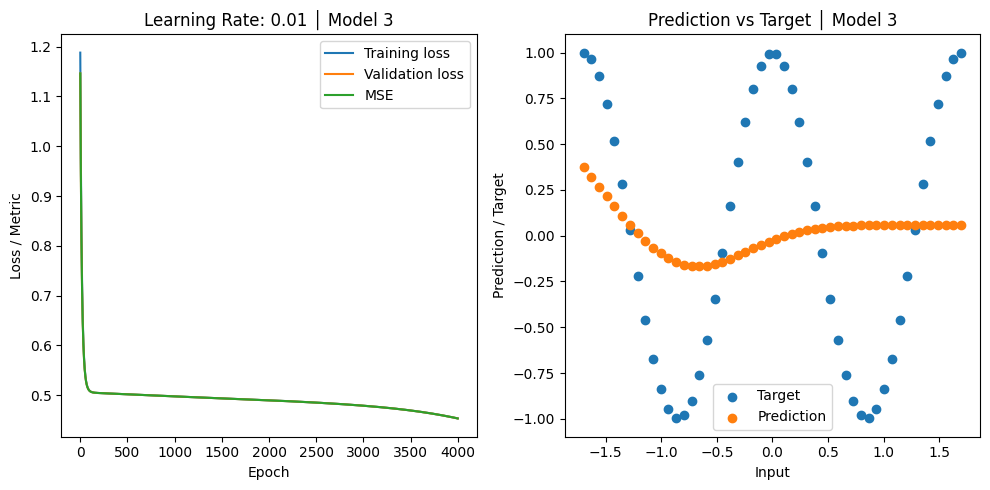


--- Training with Learning Rate: 0.02 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.891206  validation 0.852067  MSE 0.852067
Epoch 101     train 0.509229  validation 0.509196  MSE 0.509196
Epoch 201     train 0.506784  validation 0.506763  MSE 0.506763
Epoch 301     train 0.504823  validation 0.504805  MSE 0.504805
Epoch 401     train 0.503158  validation 0.503143  MSE 0.503143
Epoch 501     train 0.501715  validation 0.501702  MSE 0.501702
Epoch 601     train 0.500435  validation 0.500423  MSE 0.500423
Epoch 701     train 0.499275  validation 0.499264  MSE 0.499264
Epoch 801     train 0.498203  validation 0.498193  MSE 0.498193
Epoch 901     train 0.497200  validation 0.497190  MSE 0.497190
Epoch 1001    

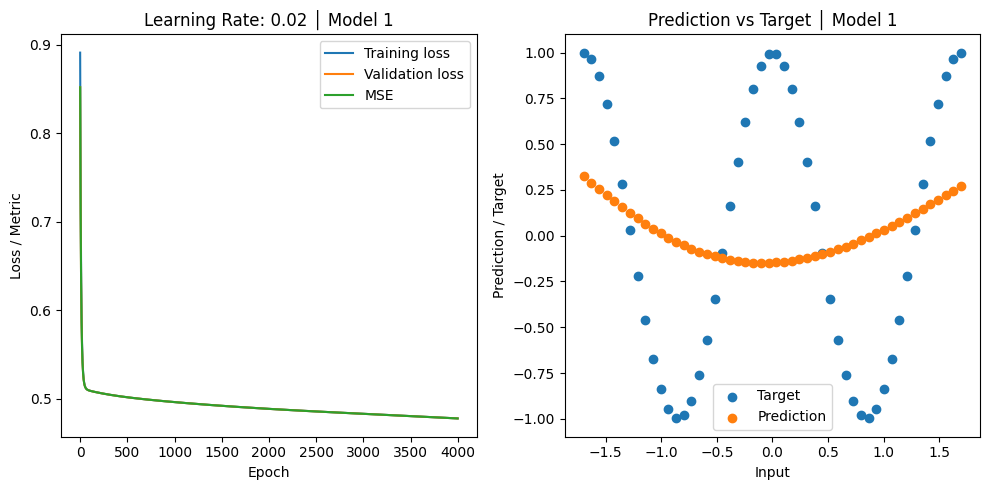


--- Training with Learning Rate: 0.02 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.932395  validation 0.883184  MSE 0.883184
Epoch 101     train 0.508157  validation 0.508086  MSE 0.508086
Epoch 201     train 0.505784  validation 0.505773  MSE 0.505773
Epoch 301     train 0.504679  validation 0.504668  MSE 0.504668
Epoch 401     train 0.503522  validation 0.503510  MSE 0.503510
Epoch 501     train 0.502286  validation 0.502274  MSE 0.502274
Epoch 601     train 0.500960  validation 0.500946  MSE 0.500946
Epoch 701     train 0.499536  validation 0.499521  MSE 0.499521
Epoch 801     train 0.498011  validation 0.497996  MSE 0.497996
Epoch 901     train 0.496391  validation 0.496374  MSE 0.496374
Epoch 1001    

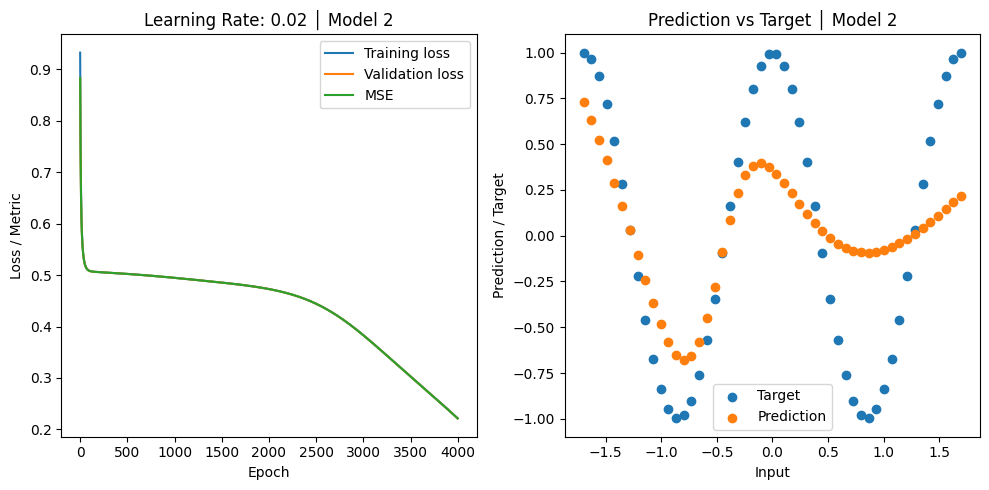


--- Training with Learning Rate: 0.02 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.912521  validation 0.864846  MSE 0.864846
Epoch 101     train 0.510717  validation 0.510679  MSE 0.510679
Epoch 201     train 0.507388  validation 0.507358  MSE 0.507358
Epoch 301     train 0.504730  validation 0.504706  MSE 0.504706
Epoch 401     train 0.502531  validation 0.502510  MSE 0.502510
Epoch 501     train 0.500635  validation 0.500617  MSE 0.500617
Epoch 601     train 0.498934  validation 0.498918  MSE 0.498918
Epoch 701     train 0.497363  validation 0.497348  MSE 0.497348
Epoch 801     train 0.495887  validation 0.495872  MSE 0.495872
Epoch 901     train 0.494488  validation 0.494475  MSE 0.494475
Epoch 1001    

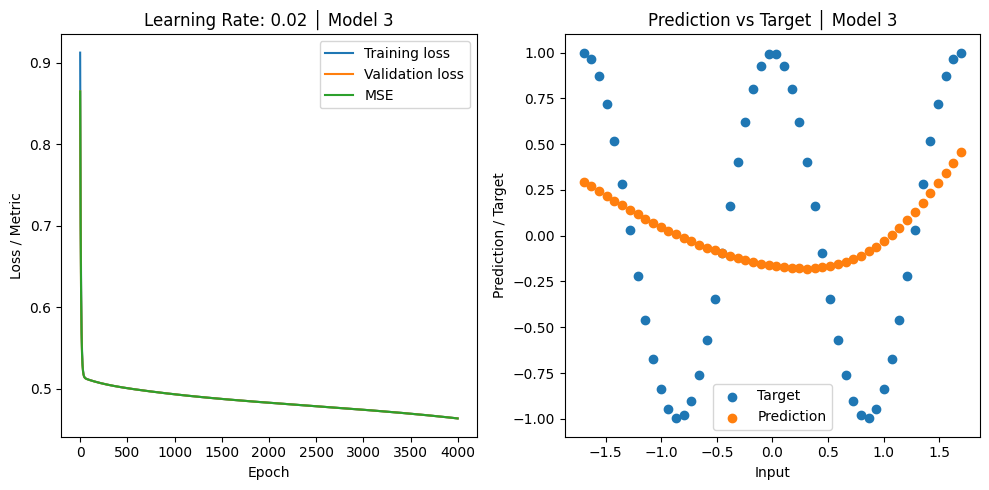


--- Training with Learning Rate: 0.05 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.555022  validation 0.546300  MSE 0.546300
Epoch 101     train 0.518457  validation 0.518386  MSE 0.518386
Epoch 201     train 0.513425  validation 0.513390  MSE 0.513390
Epoch 301     train 0.510720  validation 0.510699  MSE 0.510699
Epoch 401     train 0.508860  validation 0.508843  MSE 0.508843
Epoch 501     train 0.507213  validation 0.507196  MSE 0.507196
Epoch 601     train 0.505547  validation 0.505530  MSE 0.505530
Epoch 701     train 0.503804  validation 0.503786  MSE 0.503786
Epoch 801     train 0.501927  validation 0.501908  MSE 0.501908
Epoch 901     train 0.499832  validation 0.499809  MSE 0.499809
Epoch 1001    

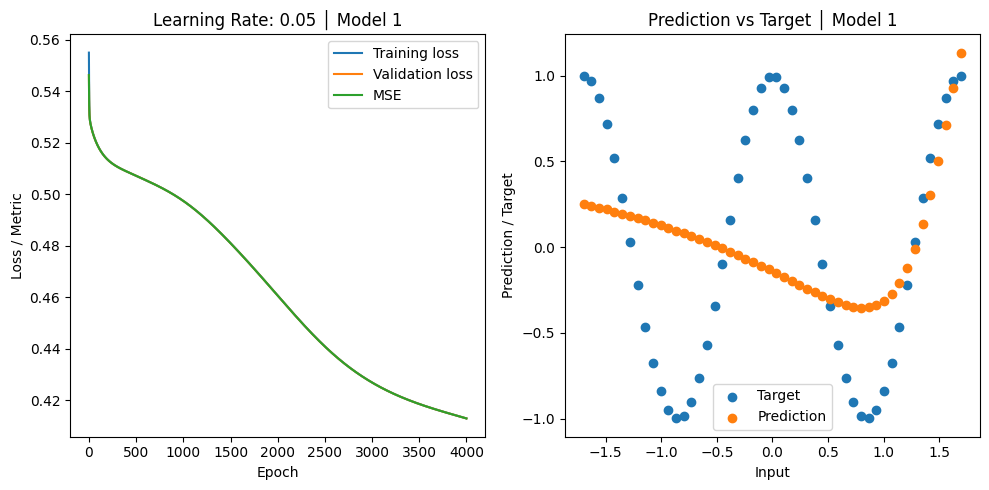


--- Training with Learning Rate: 0.05 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.511209  validation 0.511014  MSE 0.511014
Epoch 101     train 0.501998  validation 0.501932  MSE 0.501932
Epoch 201     train 0.496189  validation 0.496137  MSE 0.496137
Epoch 301     train 0.491506  validation 0.491464  MSE 0.491464
Epoch 401     train 0.487604  validation 0.487568  MSE 0.487568
Epoch 501     train 0.484290  validation 0.484259  MSE 0.484259
Epoch 601     train 0.481377  validation 0.481349  MSE 0.481349
Epoch 701     train 0.478710  validation 0.478684  MSE 0.478684
Epoch 801     train 0.476174  validation 0.476149  MSE 0.476149
Epoch 901     train 0.473682  validation 0.473657  MSE 0.473657
Epoch 1001    

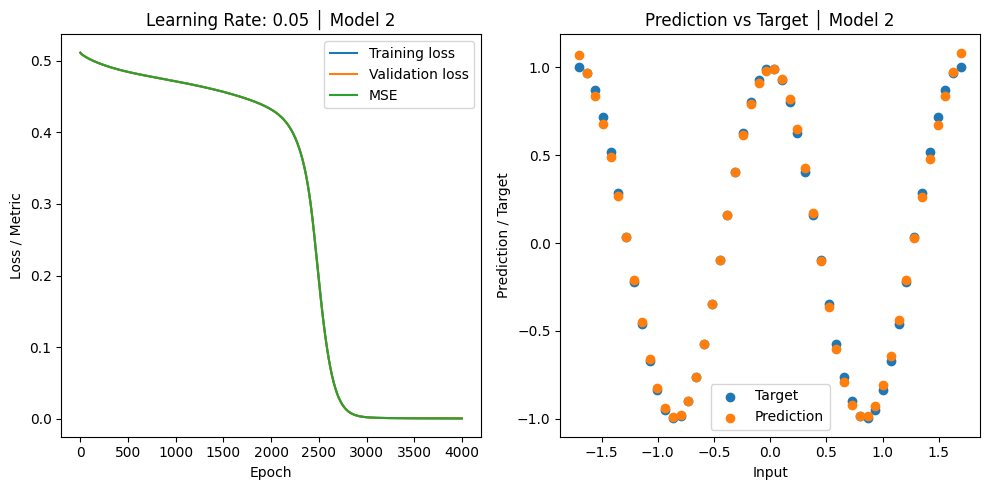


--- Training with Learning Rate: 0.05 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.516956  validation 0.514197  MSE 0.514197
Epoch 101     train 0.504346  validation 0.504313  MSE 0.504313
Epoch 201     train 0.500786  validation 0.500749  MSE 0.500749
Epoch 301     train 0.497147  validation 0.497112  MSE 0.497112
Epoch 401     train 0.493744  validation 0.493711  MSE 0.493711
Epoch 501     train 0.490698  validation 0.490669  MSE 0.490669
Epoch 601     train 0.488020  validation 0.487995  MSE 0.487995
Epoch 701     train 0.485634  validation 0.485611  MSE 0.485611
Epoch 801     train 0.483427  validation 0.483405  MSE 0.483405
Epoch 901     train 0.481292  validation 0.481270  MSE 0.481270
Epoch 1001    

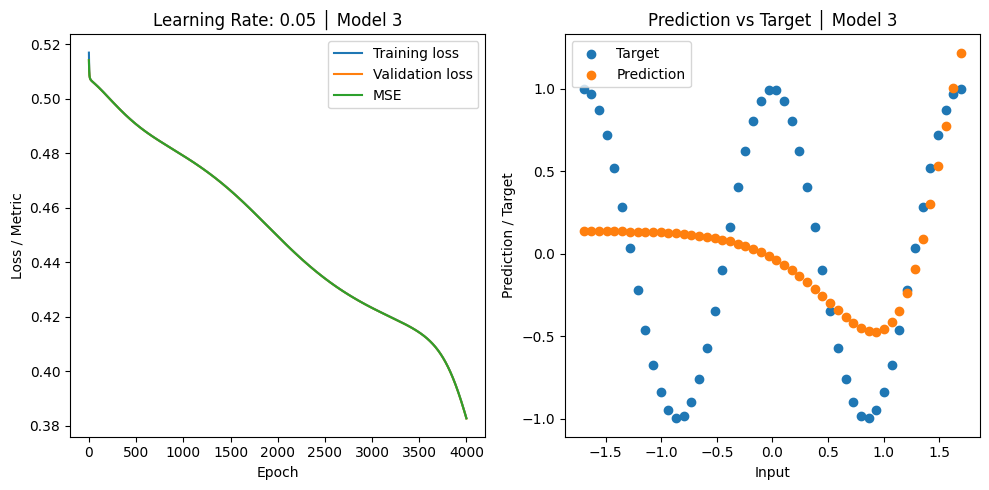

CPU times: user 1min 59s, sys: 275 ms, total: 2min
Wall time: 2min 2s


In [ ]:
%%time

# Generate training data
x_trn, d_trn = regr1(50, 2, 0, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std


# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
learning_rate_lists = [0.001,0.005,0.01,0.02,0.05]          # 5 different learning rates
loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 4000
minibatch_size = 50

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Initialized List of MSEs to Records of metrics
MSEs_lr = []


# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                        torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

for learning_rate in learning_rate_lists:
  # Define the network, cost function and training settings
  # Initialized List of MSEs to Records of metrics of three runs with the same lr
  MSEs = []
  for i in range(3):
    model_ex1 = Network(
        inputs=1,            # number of input nodes
        outputs=1,           # number of output nodes
        nodes=[4],           # number of nodes in hidden layer
        activation=nn.Tanh,  # activation function in hidden layer
        out_activation=None  # activation function in output layer (if not linear)
        ).to(device)         # move data to GPU or keep with CPU

    # Set up the optimizer
    optimizer = opt_method(model_ex1.parameters(), lr=learning_rate)

    # Print a summary of the model
    print(f"\n--- Training with Learning Rate: {learning_rate} ---")
    print(model_ex1)


    # Train the network and print the progress
    train_loss, val_loss, metrics_res = train_loop(
        model=model_ex1,
        train_dataloader=dl_trn,
        val_dataloader=dl_trn, # Test with the training data
        loss_fn=loss_fn,
        metrics=metrics,
        optimizer=optimizer,
        print_every=100,
        epochs=number_epochs)

    # Record performance metrics for MSEs list
    for n, v in metrics_res.items():
      if torch.isreal(v[-1]):
          print(f"{n} {v[-1]:<7g}; Type: {type(v[-1])}")
          MSEs.append(v[-1])



    # Predict output on the training data
    d_pred = model_ex1.predict(x_trn)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title(f"Learning Rate: {learning_rate} │ Model {i+1}")
    plot_training(train_loss, val_loss, metrics_res, ax = ax[0])

    ax[1].set_ylabel('Prediction / Target')
    ax[1].set_xlabel('Input')
    ax[1].scatter(x_trn, d_trn, label='Target')
    ax[1].scatter(x_trn, d_pred, label='Prediction')
    ax[1].set_title(f'Prediction vs Target │ Model {i+1}')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

  MSEs_lr.append(np.mean([m.item() for m in MSEs])) # Use .item() to get scalar value from tensor

In [ ]:
for lr in learning_rate_lists:
  print(f"Average MSE for learning rate {lr}: {MSEs_lr[learning_rate_lists.index(lr)]:.4f}")


Average MSE for learning rate 0.001: 0.5092
Average MSE for learning rate 0.005: 0.4933
Average MSE for learning rate 0.01: 0.4781
Average MSE for learning rate 0.02: 0.3876
Average MSE for learning rate 0.05: 0.2654


## Question 3, vary (mini)batch size
We now (hopefully) have discovered that the learning rate influences the efficiency of the loss minimization. We will now look at what happens when we use *stochastic gradient descent*, meaning that we will have a "batch size" that is smaller the the size of the training data. (We now adapt to the language of ANN packages such as PyTorch and use the word "batch" where most literature would use "mini-batch".) Use a fixed learning rate of 0.05, but test different batch sizes in the range 1 to 50. Train three different networks for each batch size, but this time record if the training was successful (i.e. MSE < 0.01) and approximately after how many epochs the good solution was found. **Present and discuss your findings**.


--- Training with Batch Size: 1 & Model 1 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.263974  validation 0.782803  MSE 0.782803
Epoch 101     train 0.007667  validation 0.048978  MSE 0.048978
Epoch 201     train 0.000972  validation 0.001494  MSE 0.001494
Epoch 301     train 0.001113  validation 0.001691  MSE 0.001691
Epoch 401     train 0.001086  validation 0.001578  MSE 0.001578
Epoch 501     train 0.000997  validation 0.001398  MSE 0.001398
Epoch 601     train 0.000888  validation 0.001207  MSE 0.001207
Epoch 701     train 0.000781  validation 0.001030  MSE 0.001030
Epoch 801     train 0.000685  validation 0.000874  MSE 0.000874
Epoch 901     train 0.000600  validation 0.000741  MSE 0.000741
Epoch 1001

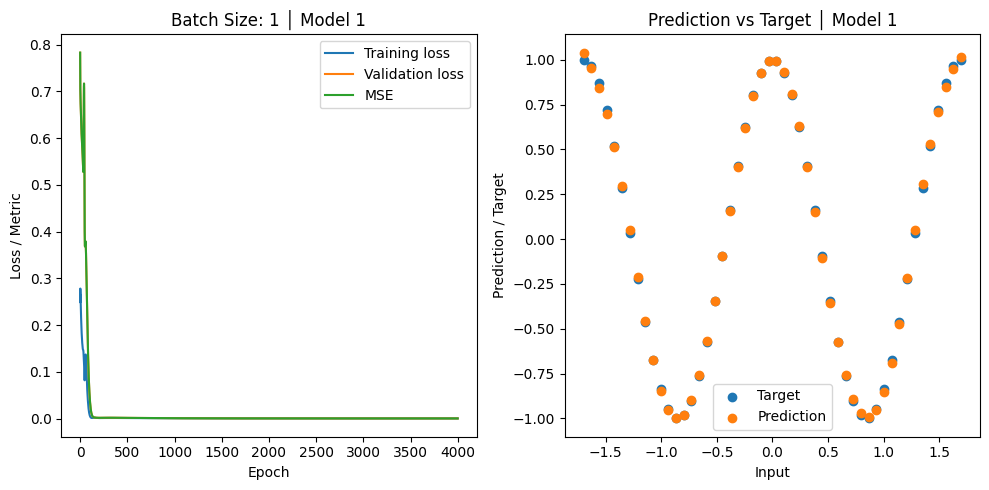


--- Training with Batch Size: 1 & Model 2 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.380327  validation 0.749036  MSE 0.749036
Epoch 101     train 0.095618  validation 0.760184  MSE 0.760184
Epoch 201     train 0.001377  validation 0.002332  MSE 0.002332
Epoch 301     train 0.000882  validation 0.001357  MSE 0.001357
Epoch 401     train 0.000935  validation 0.001309  MSE 0.001309
Epoch 501     train 0.000899  validation 0.001212  MSE 0.001212
Epoch 601     train 0.000819  validation 0.001069  MSE 0.001069
Epoch 701     train 0.000728  validation 0.000920  MSE 0.000920
Epoch 801     train 0.000641  validation 0.000783  MSE 0.000783
Epoch 901     train 0.000564  validation 0.000665  MSE 0.000665
Epoch 1001

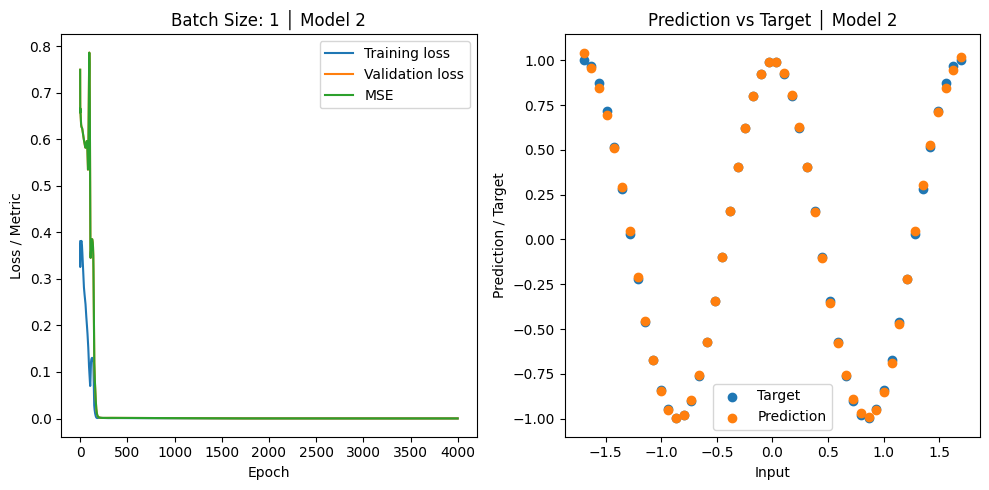


--- Training with Batch Size: 1 & Model 3 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.271480  validation 0.936586  MSE 0.936586
Epoch 101     train 0.079027  validation 0.239700  MSE 0.239700
Epoch 201     train 0.001142  validation 0.001698  MSE 0.001698
Epoch 301     train 0.001018  validation 0.001698  MSE 0.001698
Epoch 401     train 0.001076  validation 0.001638  MSE 0.001638
Epoch 501     train 0.001046  validation 0.001515  MSE 0.001515
Epoch 601     train 0.000955  validation 0.001338  MSE 0.001338
Epoch 701     train 0.000847  validation 0.001151  MSE 0.001151
Epoch 801     train 0.000741  validation 0.000979  MSE 0.000979
Epoch 901     train 0.000646  validation 0.000827  MSE 0.000827
Epoch 1001

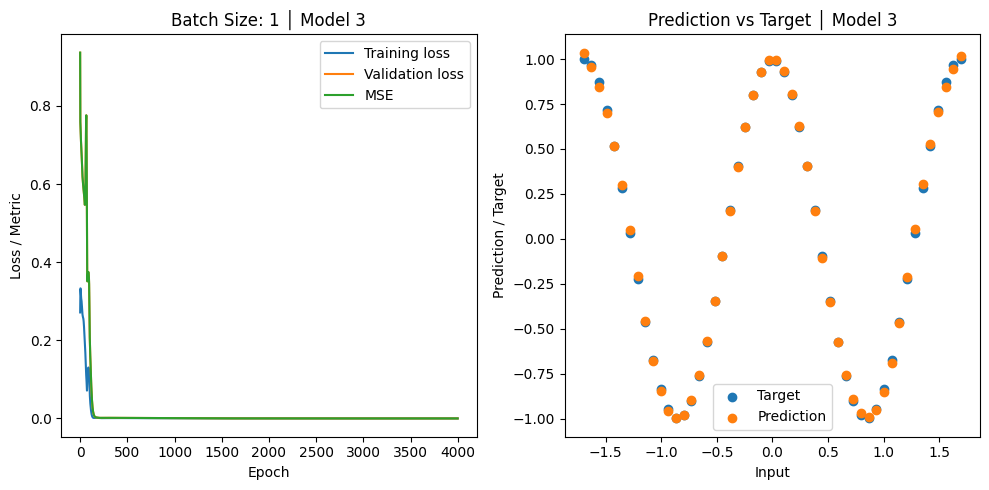


--- Training with Batch Size: 5 & Model 1 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.712088  validation 0.517594  MSE 0.517594
Epoch 101     train 0.560457  validation 0.509777  MSE 0.509777
Epoch 201     train 0.555512  validation 0.509655  MSE 0.509655
Epoch 301     train 0.555454  validation 0.509655  MSE 0.509655
Epoch 401     train 0.555451  validation 0.509655  MSE 0.509655
Epoch 501     train 0.555451  validation 0.509655  MSE 0.509655
Epoch 601     train 0.555451  validation 0.509655  MSE 0.509655
Epoch 701     train 0.555451  validation 0.509655  MSE 0.509655
Epoch 801     train 0.555451  validation 0.509655  MSE 0.509655
Epoch 901     train 0.555451  validation 0.509655  MSE 0.509655
Epoch 1001

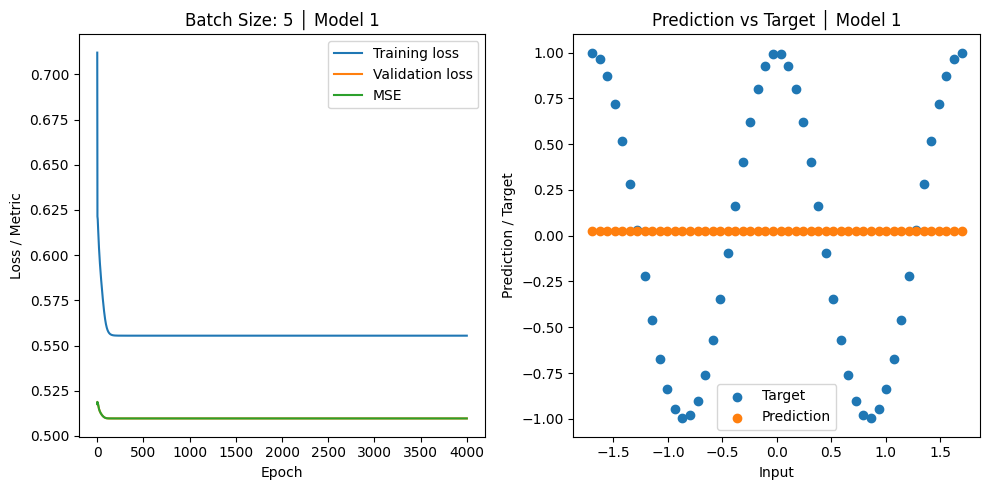


--- Training with Batch Size: 5 & Model 2 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.650737  validation 0.514724  MSE 0.514724
Epoch 101     train 0.584812  validation 0.495847  MSE 0.495847
Epoch 201     train 0.580020  validation 0.484837  MSE 0.484837
Epoch 301     train 0.545688  validation 0.451616  MSE 0.451616
Epoch 401     train 0.511719  validation 0.423677  MSE 0.423677
Epoch 501     train 0.424632  validation 0.354302  MSE 0.354302
Epoch 601     train 0.300733  validation 0.229799  MSE 0.229799
Epoch 701     train 0.077463  validation 0.050193  MSE 0.050193
Epoch 801     train 0.001499  validation 0.001367  MSE 0.001367
Epoch 901     train 0.001187  validation 0.001138  MSE 0.001138
Epoch 1001

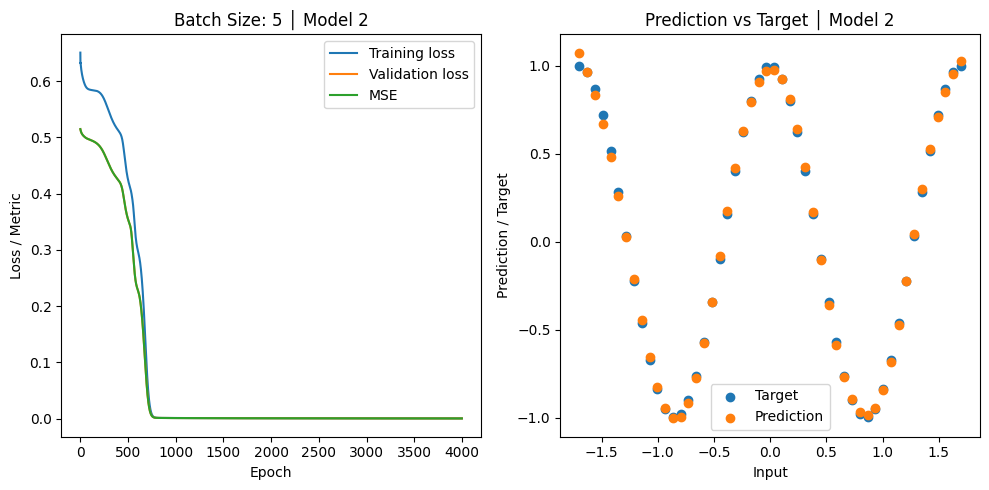


--- Training with Batch Size: 5 & Model 3 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.616682  validation 0.507926  MSE 0.507926
Epoch 101     train 0.596074  validation 0.499608  MSE 0.499608
Epoch 201     train 0.584843  validation 0.494160  MSE 0.494160
Epoch 301     train 0.576637  validation 0.480854  MSE 0.480854
Epoch 401     train 0.545367  validation 0.448287  MSE 0.448287
Epoch 501     train 0.506162  validation 0.409948  MSE 0.409948
Epoch 601     train 0.420985  validation 0.338628  MSE 0.338628
Epoch 701     train 0.395746  validation 0.319058  MSE 0.319058
Epoch 801     train 0.389914  validation 0.314251  MSE 0.314251
Epoch 901     train 0.387324  validation 0.312022  MSE 0.312022
Epoch 1001

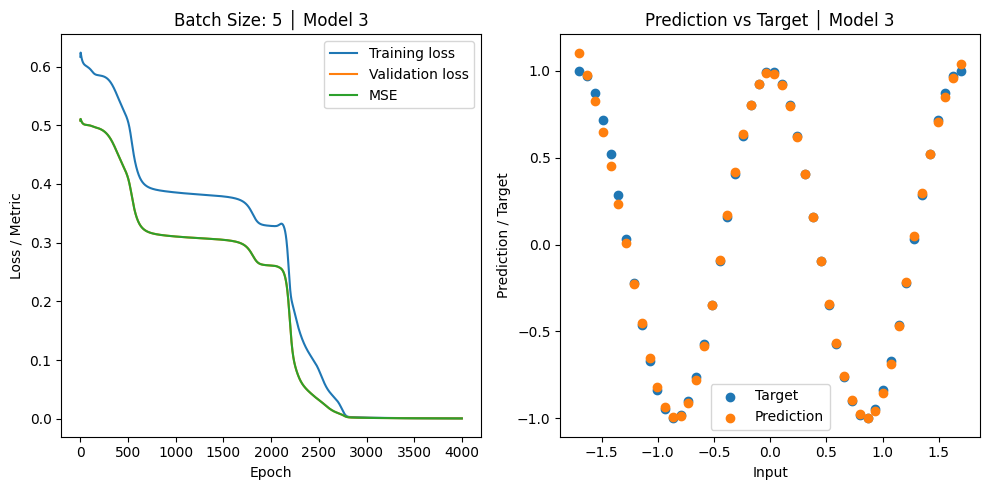


--- Training with Batch Size: 10 & Model 1 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.783979  validation 0.534213  MSE 0.534213
Epoch 101     train 0.573676  validation 0.498945  MSE 0.498945
Epoch 201     train 0.563219  validation 0.495767  MSE 0.495767
Epoch 301     train 0.561089  validation 0.492950  MSE 0.492950
Epoch 401     train 0.561747  validation 0.490497  MSE 0.490497
Epoch 501     train 0.562760  validation 0.488148  MSE 0.488148
Epoch 601     train 0.563646  validation 0.485583  MSE 0.485583
Epoch 701     train 0.563954  validation 0.482297  MSE 0.482297
Epoch 801     train 0.562448  validation 0.477268  MSE 0.477268
Epoch 901     train 0.556432  validation 0.468743  MSE 0.468743
Epoch 100

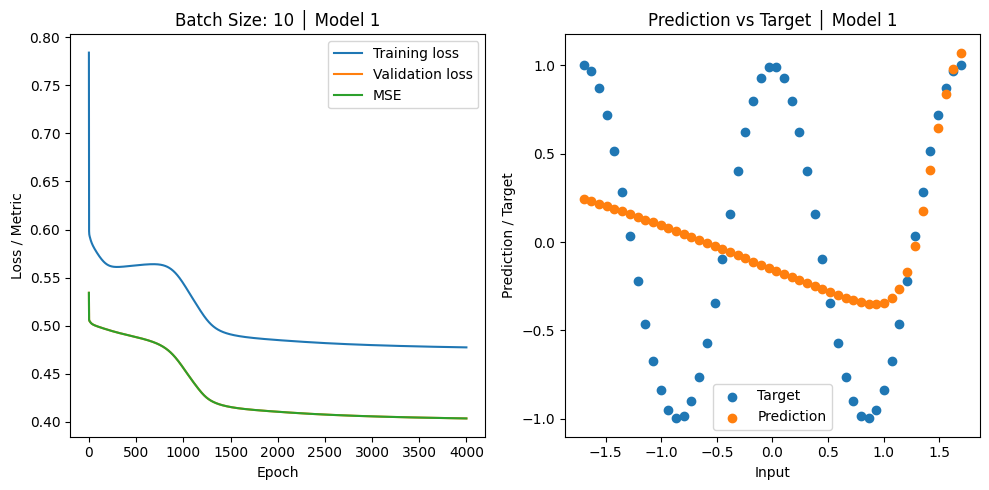


--- Training with Batch Size: 10 & Model 2 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.753939  validation 0.563090  MSE 0.563090
Epoch 101     train 0.559012  validation 0.509128  MSE 0.509128
Epoch 201     train 0.552643  validation 0.508069  MSE 0.508069
Epoch 301     train 0.550808  validation 0.508343  MSE 0.508343
Epoch 401     train 0.548455  validation 0.509076  MSE 0.509076
Epoch 501     train 0.545382  validation 0.509547  MSE 0.509547
Epoch 601     train 0.543471  validation 0.509609  MSE 0.509609
Epoch 701     train 0.542866  validation 0.509603  MSE 0.509603
Epoch 801     train 0.542702  validation 0.509601  MSE 0.509601
Epoch 901     train 0.542654  validation 0.509601  MSE 0.509601
Epoch 100

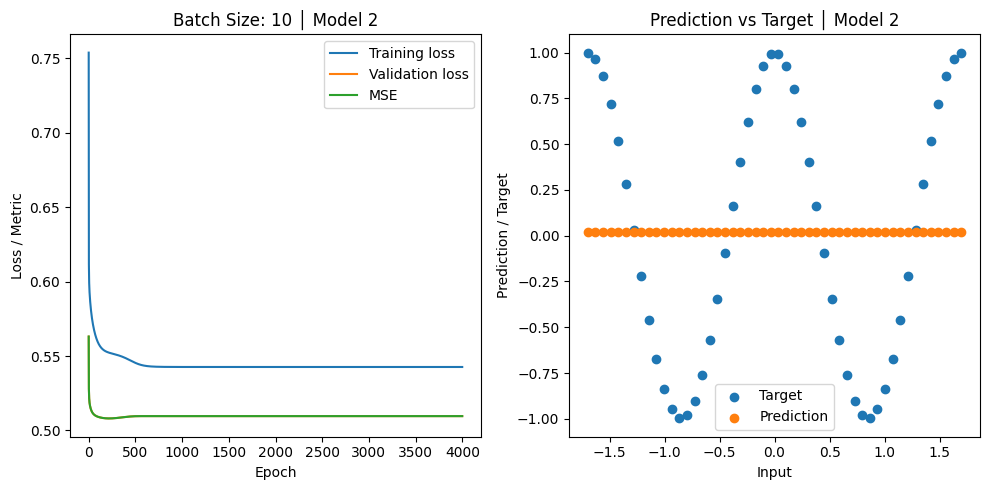


--- Training with Batch Size: 10 & Model 3 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.651650  validation 0.522758  MSE 0.522758
Epoch 101     train 0.564518  validation 0.496368  MSE 0.496368
Epoch 201     train 0.561366  validation 0.492469  MSE 0.492469
Epoch 301     train 0.557707  validation 0.486589  MSE 0.486589
Epoch 401     train 0.551823  validation 0.477101  MSE 0.477101
Epoch 501     train 0.539882  validation 0.462659  MSE 0.462659
Epoch 601     train 0.523352  validation 0.445685  MSE 0.445685
Epoch 701     train 0.508895  validation 0.431664  MSE 0.431664
Epoch 801     train 0.499699  validation 0.422840  MSE 0.422840
Epoch 901     train 0.494176  validation 0.416859  MSE 0.416859
Epoch 100

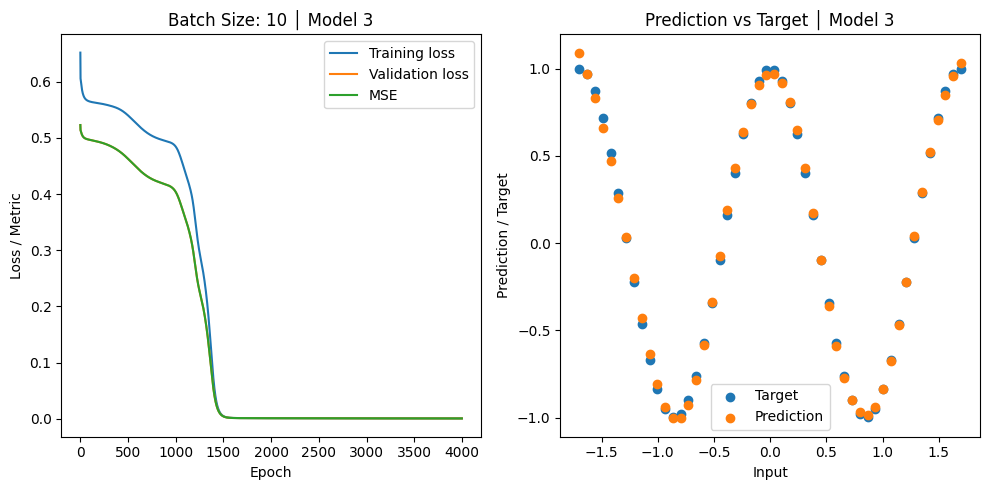


--- Training with Batch Size: 25 & Model 1 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.554543  validation 0.533027  MSE 0.533027
Epoch 101     train 0.494509  validation 0.493921  MSE 0.493921
Epoch 201     train 0.477745  validation 0.476910  MSE 0.476910
Epoch 301     train 0.434862  validation 0.433429  MSE 0.433429
Epoch 401     train 0.343015  validation 0.341061  MSE 0.341061
Epoch 501     train 0.209243  validation 0.207530  MSE 0.207530
Epoch 601     train 0.091358  validation 0.090441  MSE 0.090441
Epoch 701     train 0.034975  validation 0.034587  MSE 0.034587
Epoch 801     train 0.014790  validation 0.014626  MSE 0.014626
Epoch 901     train 0.007238  validation 0.007166  MSE 0.007166
Epoch 100

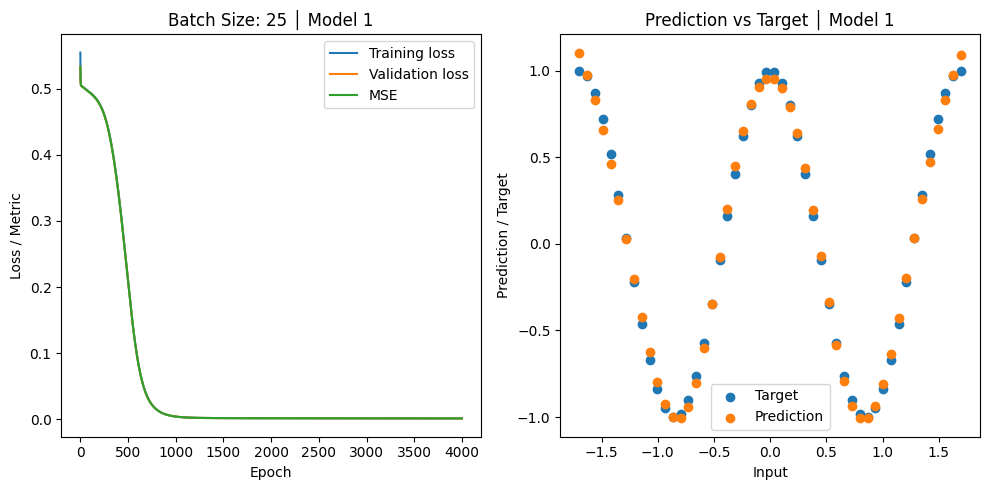


--- Training with Batch Size: 25 & Model 2 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.608274  validation 0.574385  MSE 0.574385
Epoch 101     train 0.498477  validation 0.498264  MSE 0.498264
Epoch 201     train 0.491115  validation 0.490883  MSE 0.490883
Epoch 301     train 0.485696  validation 0.485440  MSE 0.485440
Epoch 401     train 0.480948  validation 0.480671  MSE 0.480671
Epoch 501     train 0.476287  validation 0.475987  MSE 0.475987
Epoch 601     train 0.471330  validation 0.471002  MSE 0.471002
Epoch 701     train 0.465869  validation 0.465504  MSE 0.465504
Epoch 801     train 0.459920  validation 0.459508  MSE 0.459508
Epoch 901     train 0.453715  validation 0.453246  MSE 0.453246
Epoch 100

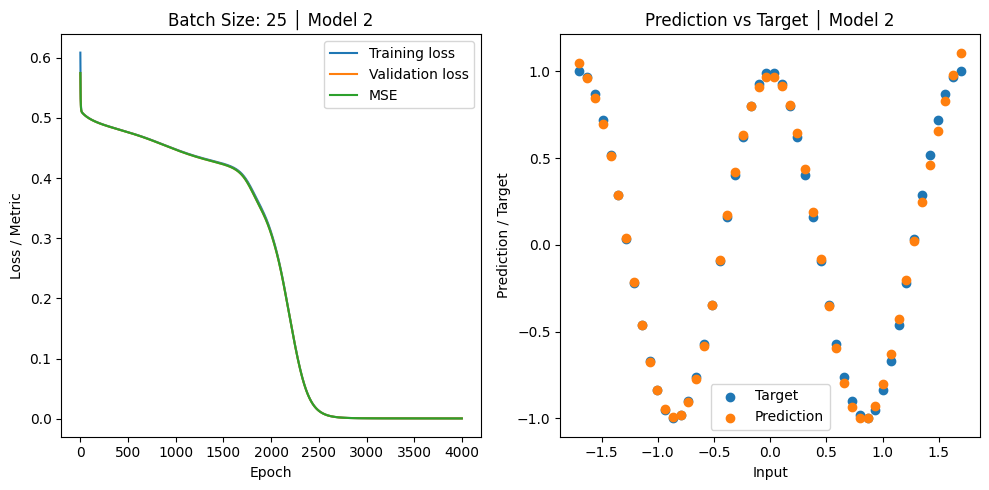


--- Training with Batch Size: 25 & Model 3 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.647190  validation 0.590120  MSE 0.590120
Epoch 101     train 0.510335  validation 0.510229  MSE 0.510229
Epoch 201     train 0.507669  validation 0.507519  MSE 0.507519
Epoch 301     train 0.502841  validation 0.502631  MSE 0.502631
Epoch 401     train 0.495004  validation 0.494737  MSE 0.494737
Epoch 501     train 0.487701  validation 0.487357  MSE 0.487357
Epoch 601     train 0.480544  validation 0.480039  MSE 0.480039
Epoch 701     train 0.468474  validation 0.467645  MSE 0.467645
Epoch 801     train 0.434140  validation 0.432571  MSE 0.432571
Epoch 901     train 0.344658  validation 0.342202  MSE 0.342202
Epoch 100

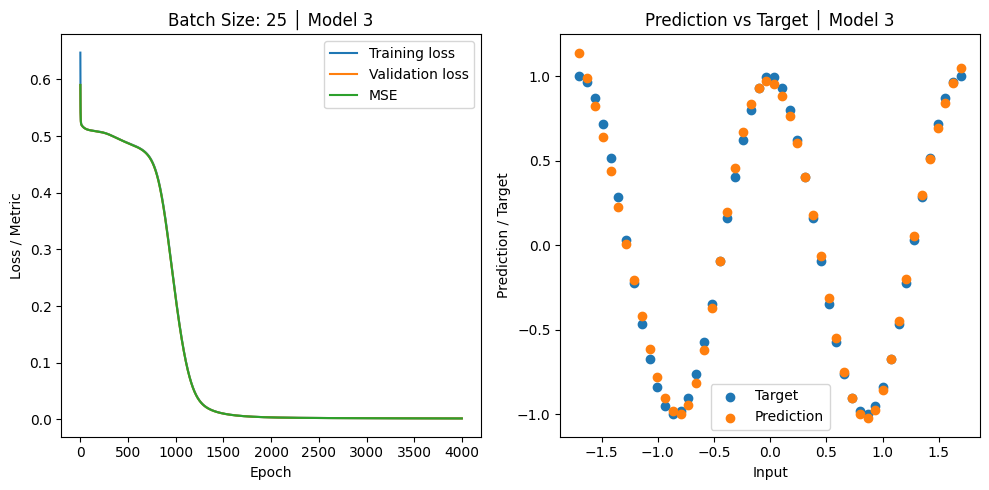


--- Training with Batch Size: 50 & Model 1 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 1.089740  validation 0.871461  MSE 0.871461
Epoch 101     train 0.499462  validation 0.499432  MSE 0.499432
Epoch 201     train 0.496644  validation 0.496617  MSE 0.496617
Epoch 301     train 0.493970  validation 0.493944  MSE 0.493944
Epoch 401     train 0.491324  validation 0.491297  MSE 0.491297
Epoch 501     train 0.488656  validation 0.488629  MSE 0.488629
Epoch 601     train 0.485952  validation 0.485925  MSE 0.485925
Epoch 701     train 0.483206  validation 0.483179  MSE 0.483179
Epoch 801     train 0.480414  validation 0.480386  MSE 0.480386
Epoch 901     train 0.477567  validation 0.477538  MSE 0.477538
Epoch 100

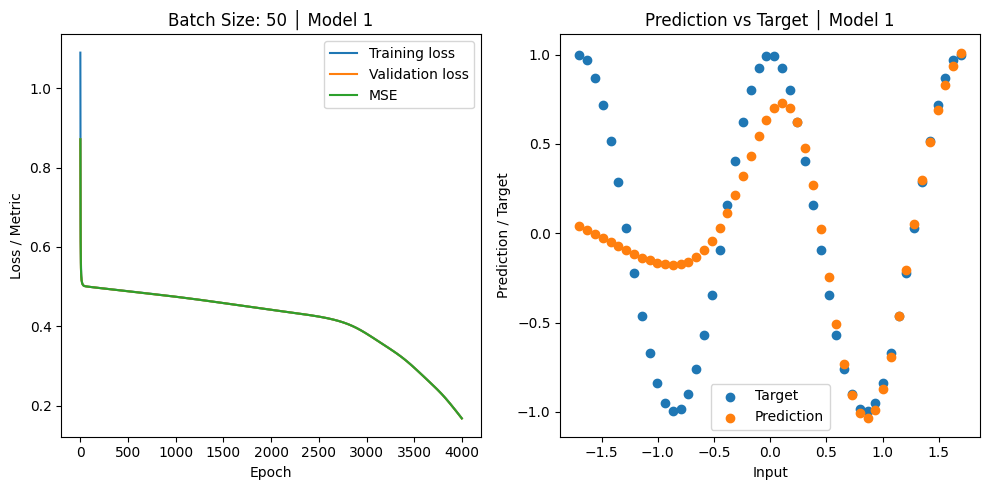


--- Training with Batch Size: 50 & Model 2 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.609031  validation 0.578410  MSE 0.578410
Epoch 101     train 0.509447  validation 0.509445  MSE 0.509445
Epoch 201     train 0.509227  validation 0.509225  MSE 0.509225
Epoch 301     train 0.508967  validation 0.508964  MSE 0.508964
Epoch 401     train 0.508629  validation 0.508625  MSE 0.508625
Epoch 501     train 0.508163  validation 0.508157  MSE 0.508157
Epoch 601     train 0.507500  validation 0.507492  MSE 0.507492
Epoch 701     train 0.506547  validation 0.506536  MSE 0.506536
Epoch 801     train 0.505182  validation 0.505166  MSE 0.505166
Epoch 901     train 0.503247  validation 0.503224  MSE 0.503224
Epoch 100

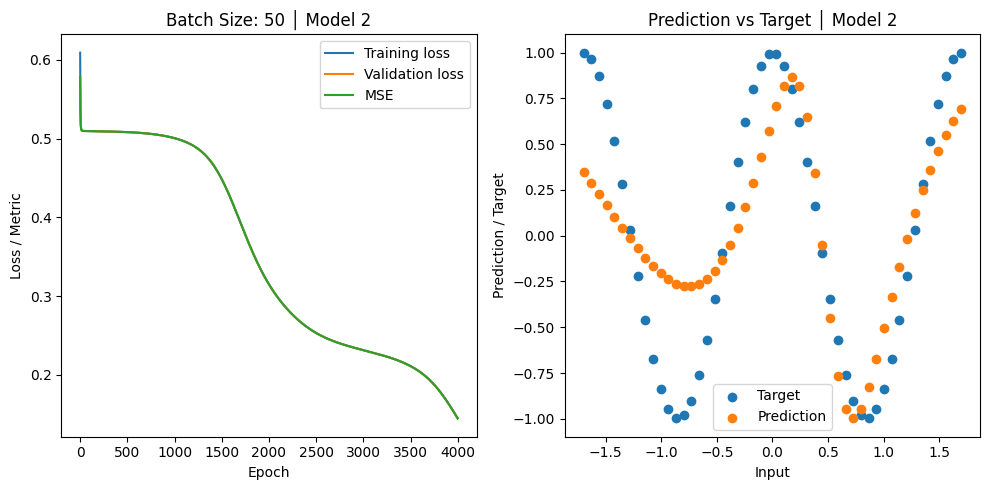


--- Training with Batch Size: 50 & Model 3 ---
Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=4, out_features=1, bias=True)
  )
)
Trainable parameters: 13
Named parameters:
  layer1.weight: 4
  layer1.bias: 4
  layerN.weight: 4
  layerN.bias: 1

Epoch 1       train 0.511248  validation 0.509493  MSE 0.509493
Epoch 101     train 0.504422  validation 0.504394  MSE 0.504394
Epoch 201     train 0.501429  validation 0.501397  MSE 0.501397
Epoch 301     train 0.498188  validation 0.498155  MSE 0.498155
Epoch 401     train 0.494849  validation 0.494815  MSE 0.494815
Epoch 501     train 0.491402  validation 0.491367  MSE 0.491367
Epoch 601     train 0.487841  validation 0.487805  MSE 0.487805
Epoch 701     train 0.484216  validation 0.484180  MSE 0.484180
Epoch 801     train 0.480588  validation 0.480552  MSE 0.480552
Epoch 901     train 0.476975  validation 0.476939  MSE 0.476939
Epoch 100

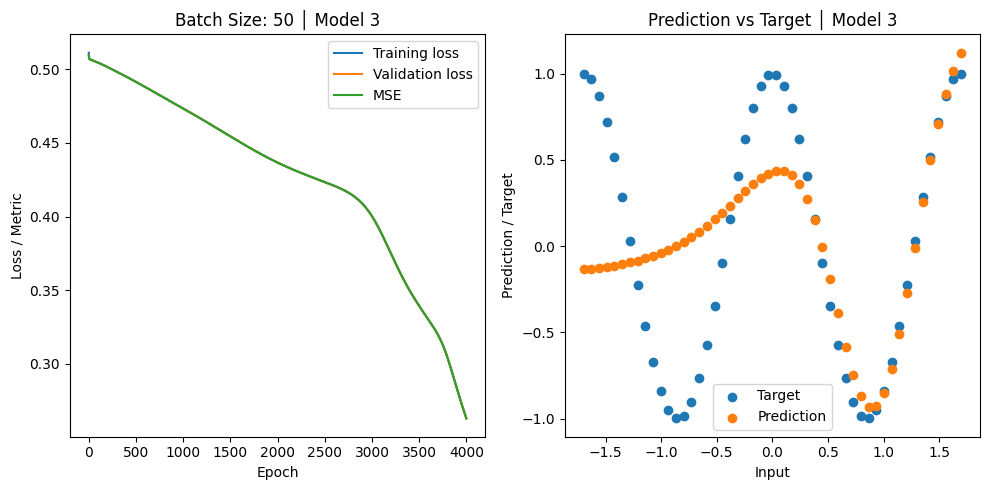

CPU times: user 12min 7s, sys: 823 ms, total: 12min 8s
Wall time: 12min 13s


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
%%time

# Generate training data
x_trn, d_trn = regr1(50, 2, 0, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std


# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
# Hyperparameters
batch_size_list = [1, 5, 10, 25, 50]
learning_rate = 0.05

loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 4000
#minibatch_size = 50

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Initialized List of MSEs to Records of metrics
MSEs_bs = [] # record only if MSE < 0.01, i.e. sucessful training


# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                        torch.tensor(d_trn, device=device, dtype=dtype_torch))

for bs in batch_size_list:
  # Define the network, cost function and training settings
  # Initialized List of MSEs to Records of metrics of three runs with the same lr
  MSEs = []

  for i in range(3):
    # Create a batch loader for the training data
    dl_trn = DataLoader(dset_trn, batch_size=bs)
    model_ex1 = Network(
        inputs=1,            # number of input nodes
        outputs=1,           # number of output nodes
        nodes=[4],           # number of nodes in hidden layer
        activation=nn.Tanh,  # activation function in hidden layer
        out_activation=None  # activation function in output layer (if not linear)
        ).to(device)         # move data to GPU or keep with CPU

    # Set up the optimizer
    optimizer = opt_method(model_ex1.parameters(), lr=learning_rate)

    # Print a summary of the model
    print(f"\n--- Training with Batch Size: {bs} & Model {i+1} ---")
    print(model_ex1)


    # Train the network and print the progress
    train_loss, val_loss, metrics_res = train_loop(
        model=model_ex1,
        train_dataloader=dl_trn,
        val_dataloader=dl_trn, # Test with the training data
        loss_fn=loss_fn,
        metrics=metrics,
        optimizer=optimizer,
        print_every=100,
        epochs=number_epochs)

    # Record performance metrics for MSEs list
    for n, v in metrics_res.items():
      if torch.isreal(v[-1]):
          print(f"{n} {v[-1]:<7g})")
          if v[-1] < 0.01:
            MSEs.append(v[-1])



    # Predict output on the training data
    d_pred = model_ex1.predict(x_trn)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title(f"Batch Size: {bs} │ Model {i+1}")
    plot_training(train_loss, val_loss, metrics_res, ax = ax[0])

    ax[1].set_ylabel('Prediction / Target')
    ax[1].set_xlabel('Input')
    ax[1].scatter(x_trn, d_trn, label='Target')
    ax[1].scatter(x_trn, d_pred, label='Prediction')
    ax[1].set_title(f'Prediction vs Target │ Model {i+1}')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

  MSEs_lr.append(np.mean([m.item() for m in MSEs])) # Use .item() to get scalar value from tensor

In [ ]:
print(MSEs_bs)

NameError: name 'MSEs_bs' is not defined

## Question 4, select good hyper-parameters
Find a combination of learning rate and batch size that gives a good solution within 1000 epochs. We always have to remember that two runs with identical hyper parameters (e.g. learning rate, batch size etc) will result in different final results. Your set of parameters should *most* of the times result in a good solution within 1000 epochs. **Present your best combination of learning rate and batch size, and its result**.

Batch size = 5 or 25 seem to be the best choices here. Should check on MSE also

LR = 0.05

Test with 1000

In [ ]:
%%time

# Generate training data
x_trn, d_trn = regr1(50, 2, 0, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std


# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
# Hyperparameters
best_batch_size_list = [5,25]
learning_rate = 0.05

loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 1000
#minibatch_size = 50

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Initialized List of MSEs to Records of metrics
MSEs_bs = [] # record only if MSE < 0.01, i.e. sucessful training


# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                        torch.tensor(d_trn, device=device, dtype=dtype_torch))

for bs in batch_size_list:
  # Define the network, cost function and training settings
  # Initialized List of MSEs to Records of metrics of three runs with the same lr
  MSEs = []

  for i in range(3):
    # Create a batch loader for the training data
    dl_trn = DataLoader(dset_trn, batch_size=bs)
    model_ex1 = Network(
        inputs=1,            # number of input nodes
        outputs=1,           # number of output nodes
        nodes=[4],           # number of nodes in hidden layer
        activation=nn.Tanh,  # activation function in hidden layer
        out_activation=None  # activation function in output layer (if not linear)
        ).to(device)         # move data to GPU or keep with CPU

    # Set up the optimizer
    optimizer = opt_method(model_ex1.parameters(), lr=learning_rate)

    # Print a summary of the model
    print(f"\n--- Training with Batch Size: {bs} & Model {i+1} ---")
    print(model_ex1)


    # Train the network and print the progress
    train_loss, val_loss, metrics_res = train_loop(
        model=model_ex1,
        train_dataloader=dl_trn,
        val_dataloader=dl_trn, # Test with the training data
        loss_fn=loss_fn,
        metrics=metrics,
        optimizer=optimizer,
        print_every=100,
        epochs=number_epochs)

    # Record performance metrics for MSEs list
    for n, v in metrics_res.items():
      if torch.isreal(v[-1]):
          print(f"{n} {v[-1]:<7g})")
          if v[-1] < 0.01:
            MSEs.append(v[-1])



    # Predict output on the training data
    d_pred = model_ex1.predict(x_trn)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title(f"Batch Size: {bs} │ Model {i+1}")
    plot_training(train_loss, val_loss, metrics_res, ax = ax[0])

    ax[1].set_ylabel('Prediction / Target')
    ax[1].set_xlabel('Input')
    ax[1].scatter(x_trn, d_trn, label='Target')
    ax[1].scatter(x_trn, d_pred, label='Prediction')
    ax[1].set_title(f'Prediction vs Target │ Model {i+1}')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

  MSEs_lr.append(np.mean([m.item() for m in MSEs])) # Use .item() to get scalar value from tensor

# CellName: Ex2 (#9)
**CellType: Exercise**  
**Cell instruction:**  

The amount of weights in the network can also influence how long time we need to train, and of course if the problem itself is complex or not. The following two questions will highlight this.

## Question 5, vary epochs
The example below will load a slightly more complex *regr1* problem (an additional quarter of a period). We will use 10 hidden nodes for this problem. Use your optimal set of learning rate and batch size as found in Q4 and train the network below. **Compare the number of epochs needed to reach a good solution with that of Q4**. Note, you may need to vary the number of epochs a lot! If you cannot find a good solution in a reasonable number of epochs, you can "revert" the problem: optimize learning rate and batch size for Q5, and the see how those hyper-parameters perform on Q4.

## Question 6, vary network size and other hyper-parameters
Use the following line to load the *regr1* data set:

`x_trn, d_trn = regr1(75, 5, 1, 0.0)`

This will create an even more challenging regression task that may need an even larger network. Your task is to find a set of hyper-parameters (learning rate, batch size, epochs, 'size of the network') that result in a good solution. You can use more than one hidden layer for this task (if you want). To create many hidden layers, add many numbers to the `layers` list, for example: `layers = [10, 5, 5]`. **Present your set of good hyper-parameters and the result**.

**Note:** If you cannot solve this task in *reasonable* time, present your best attempt!


Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=10, bias=True)
    (act1): Tanh()
    (layerN): Linear(in_features=10, out_features=1, bias=True)
  )
)
Trainable parameters: 31
Named parameters:
  layer1.weight: 10
  layer1.bias: 10
  layerN.weight: 10
  layerN.bias: 1

Epoch 1       train 0.158756  validation 0.720190  MSE 0.720191
Epoch 101     train 0.167672  validation 0.601603  MSE 0.601603
Epoch 201     train 0.030018  validation 0.087419  MSE 0.087419
Epoch 301     train 0.013680  validation 0.052465  MSE 0.052465
Epoch 401     train 0.009459  validation 0.033353  MSE 0.033353
Epoch 501     train 0.004678  validation 0.021262  MSE 0.021262
Epoch 601     train 0.002986  validation 0.015699  MSE 0.015699
Epoch 701     train 0.002284  validation 0.013185  MSE 0.013185
Epoch 801     train 0.001599  validation 0.010497  MSE 0.010497
Epoch 901     train 0.001212  validation 0.007978  MSE 0.007978
Epoch 1000    train 0.001368  validation 0.006234  M

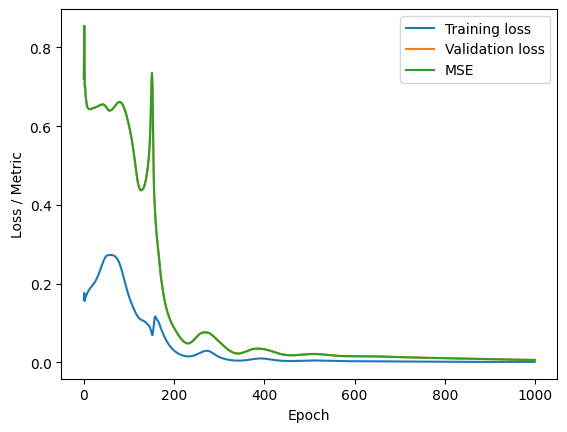

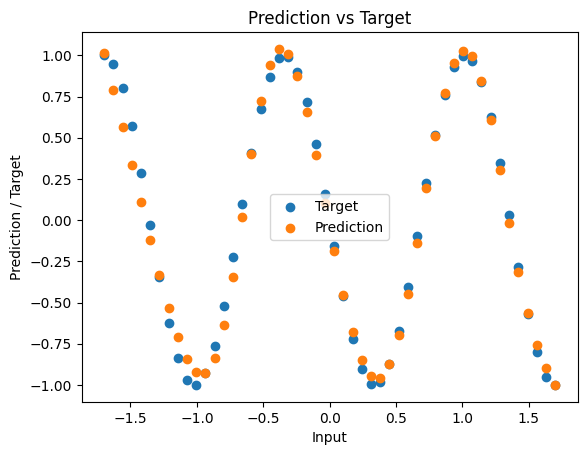

CPU times: user 57.1 s, sys: 53.2 ms, total: 57.1 s
Wall time: 1min 8s


In [7]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

# Generate training data
# For Q5:
x_trn, d_trn = regr1(50, 2.5, 0, 0.0)

# For Q6:
#x_trn, d_trn = regr1(75, 5, 1, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std

# Define the network, cost function and training settings
model_ex2 = Network(
    inputs=1,            # number of input nodes
    outputs=1,           # number of output nodes
    nodes=[10],           # number of nodes in hidden layer
    activation=nn.Tanh,  # activation function in hidden layer
    out_activation=None  # activation function in output layer (if not linear)
    ).to(device)         # move data to GPU or keep with CPU

# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
learning_rate = 0.05          # learning rate
loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 1000
minibatch_size = 1

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Print a summary of the model
print(model_ex2)

# Set up the optimizer
optimizer = opt_method(model_ex2.parameters(), lr=learning_rate)

# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex2,
    train_dataloader=dl_trn,
    val_dataloader=dl_trn, # Test with the training data
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=100,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Predict output on the training data
d_pred = model_ex2.predict(x_trn)

# Plot the result
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()

Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=1, out_features=128, bias=True)
    (act1): Tanh()
    (layer2): Linear(in_features=128, out_features=64, bias=True)
    (act2): Tanh()
    (layer3): Linear(in_features=64, out_features=32, bias=True)
    (act3): Tanh()
    (layer4): Linear(in_features=32, out_features=16, bias=True)
    (act4): Tanh()
    (layerN): Linear(in_features=16, out_features=1, bias=True)
  )
)
Trainable parameters: 11137
Named parameters:
  layer1.weight: 128
  layer1.bias: 128
  layer2.weight: 8192
  layer2.bias: 64
  layer3.weight: 2048
  layer3.bias: 32
  layer4.weight: 512
  layer4.bias: 16
  layerN.weight: 16
  layerN.bias: 1

Epoch 1       train 0.163623  validation 0.160062  MSE 0.160062
Epoch 101     train 0.157374  validation 0.157338  MSE 0.157338
Epoch 201     train 0.157305  validation 0.157274  MSE 0.157274
Epoch 301     train 0.157238  validation 0.157208  MSE 0.157208
Epoch 401     train 0.157169  validation 0.157141  MSE 0.1

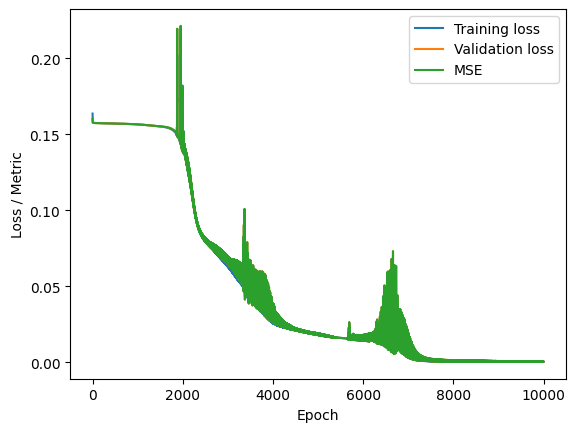

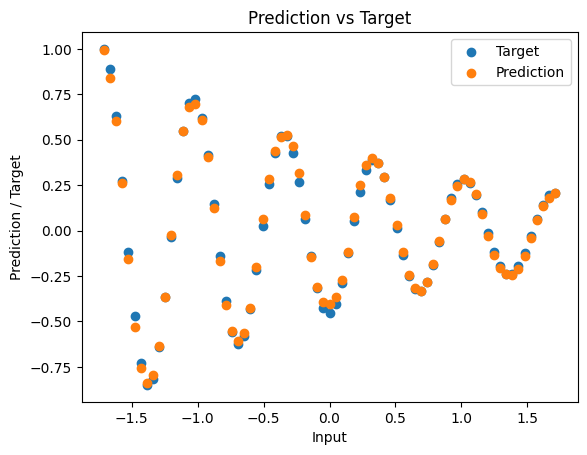

CPU times: user 1min 17s, sys: 139 ms, total: 1min 17s
Wall time: 1min 18s


In [19]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

# Generate training data
# For Q5:
#x_trn, d_trn = regr1(50, 2.5, 0, 0.0)

# For Q6:
x_trn, d_trn = regr1(75, 5, 1, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std

d_mu, d_std = standard(d_trn)
#d_trn = (d_trn - d_mu) / d_std
# Define the network, cost function and training settings
model_ex2 = Network(
    inputs=1,            # number of input nodes
    outputs=1,           # number of output nodes
    nodes=[128,64,32,16],           # number of nodes in hidden layer
    activation=nn.Tanh,  # activation function in hidden layer
    out_activation=None  # activation function in output layer (if not linear)
    ).to(device)         # move data to GPU or keep with CPU

# Optimization parameters
opt_method = torch.optim.SGD  # minimization method
learning_rate = 0.07          # learning rate
loss_fn = nn.MSELoss()        # loss function, MSE
number_epochs = 10000
minibatch_size = 32

# Additional metrics to print
metrics = {'MSE': torchmetrics.MeanSquaredError()}

# Print a summary of the model
print(model_ex2)

# Set up the optimizer
optimizer = opt_method(model_ex2.parameters(), lr=learning_rate)

# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex2,
    train_dataloader=dl_trn,
    val_dataloader=dl_trn, # Test with the training data
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=100,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Predict output on the training data
#d_pred = model_ex2.predict(x_trn)*d_std + d_mu
d_pred = model_ex2.predict(x_trn)
# Plot the result
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()

# CellName: Ex3 (#10)
**CellType: Exercise**  
**Cell instruction:**  

We will now look at the classification problem defined by the *syn2* dataset.
The cell below defines a single hidden node MLP. With this network you can only implement a linear decision boundary. Run the cell below to look at the resulting boundary that the MLP learns. The training accuracy is around 87-93%, because the data is generated randomly each time you run the code.

## Question 7, optimize hyper-parameters for classification
Your task is now to reach a larger accuracy by fitting a model with more hidden nodes (and possibly more hidden layers).
Your aim is to reach a training accuracy > 95%. To do that you need to tune the learning rate, batch size, epochs and the size of your MLP. **Present your set of hyper parameters that reach > 95% accuracy**

**Note**: To always generate exactly the same dataset each time you run the code you can set the *seed* to a value > 0.

## Question 8, change learning algorithm
We have so far only used stochastic gradient descent (SGD), but we know that there are modifications of SGD that are very popular, e.g. Adam.
**Try the Adam optimizer for Q7, and compare (qualitatively) the results and the number of epochs needed to get them.**

The interpretation of the learning rate differs a bit between SGD and Adam. Since your learning rate was optimized for SGD in Q7, you could consider optimizing it again for Adam, before you compare SGD with Adam. **Present changes you needed to make to improve the results of the Adam optimizer, if any.**

**Info**: Adam has two extra parameters. The way we call the Adam optimizer, they will be kept at their default values *beta1* = 0.9 and *beta2* = 0.999.

## Bonus tasks
The bonus tasks are provided if you have extra time and want to continue to explore methods that can further enhance the minimization of the loss function. **These tasks are not required for the course and do not influence any grading**.

The tasks listed below also mean that you have to change the code in code cell *Training* (#6). There will be links to appropriate documentation below.

* Go back to Q7 and add use a momentum add-on to SGD. **Does momentum help?** (See documentation [here](https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html))
* It is common to also introduce a mechanism that can lower the learning rate as we train. If we are using stochastic gradient descent the mini-batch gradients will never be zero, meaning that we will always make some small weight updates. PyTorch has methods that can lower the learning rate as we train (see [here](https://docs.pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)). Again go back to Q7 and now use an exponentially decaying learning rate (`ExponentialLR`). **Does it help?**



## Question 7, optimize hyper-parameters for classification
Your task is now to reach a larger accuracy by fitting a model with more hidden nodes (and possibly more hidden layers).
Your aim is to reach a training accuracy > 95%. To do that you need to tune the learning rate, batch size, epochs and the size of your MLP. **Present your set of hyper parameters that reach > 95% accuracy**

Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=2, out_features=64, bias=True)
    (act1): Tanh()
    (layer2): Linear(in_features=64, out_features=32, bias=True)
    (act2): Tanh()
    (layer3): Linear(in_features=32, out_features=16, bias=True)
    (act3): Tanh()
    (layer4): Linear(in_features=16, out_features=8, bias=True)
    (act4): Tanh()
    (layerN): Linear(in_features=8, out_features=1, bias=True)
    (actN): Sigmoid()
  )
)
Trainable parameters: 2945
Named parameters:
  layer1.weight: 128
  layer1.bias: 64
  layer2.weight: 2048
  layer2.bias: 32
  layer3.weight: 512
  layer3.bias: 16
  layer4.weight: 128
  layer4.bias: 8
  layerN.weight: 8
  layerN.bias: 1

Epoch 1       train 0.687334  validation 0.660994  accuracy 0.540000
Epoch 101     train 0.186686  validation 0.171616  accuracy 0.940000
Epoch 201     train 0.158734  validation 0.148054  accuracy 0.940000
Epoch 301     train 0.138266  validation 0.131904  accuracy 0.950000
Epoch 401     train 0.122

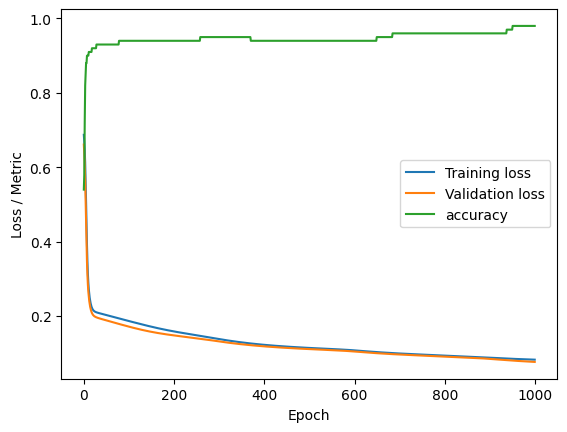

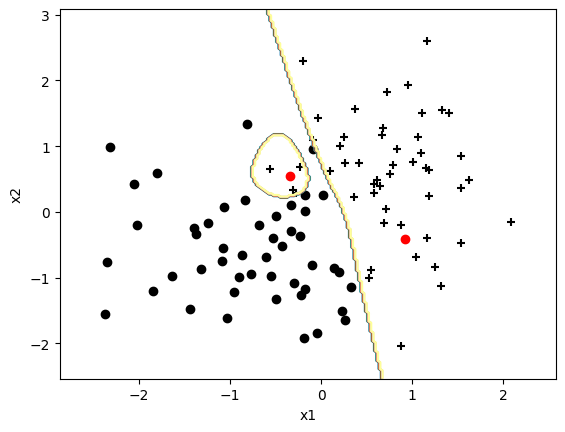

CPU times: user 11.6 s, sys: 29 ms, total: 11.6 s
Wall time: 11.7 s


In [26]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 1234
np.random.seed(seed) if seed else None

# Generate training data
x_trn, d_trn = syn2(100)

# General standardization of input data
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std

# Define the network, cost function and training settings
model_ex3 = Network(
    inputs=x_trn.shape[1],      # number of input nodes
    outputs=1,                  # number of output nodes
    nodes=[64,32,16,8],                 # number of nodes in hidden layer
    activation=nn.Tanh,         # activation function in hidden layer
    out_activation=nn.Sigmoid   # activation function in output layer
    ).to(device)                # move data to GPU or keep with CPU

# Optimization parameters
opt_method = torch.optim.SGD    # minimization method
learning_rate = 0.1             # learning rate
loss_fn = nn.BCELoss()          # loss function, binary cross entropy
number_epochs = 1000
minibatch_size = 32

# Additional metrics to print
metrics = { 'accuracy': torchmetrics.Accuracy('binary') }

# Print a summary of the model
print(model_ex3)

# Set up the optimizer
optimizer = opt_method(model_ex3.parameters(), lr=learning_rate)

# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex3,
    train_dataloader=dl_trn,
    val_dataloader=dl_trn, # Test with the training data
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=100,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Predict output on the training data
d_pred = model_ex3.predict(x_trn)

# Plot the decision boundary
decision_boundary(x_trn, d_trn, model_ex3)

## Question 8, change learning algorithm
We have so far only used stochastic gradient descent (SGD), but we know that there are modifications of SGD that are very popular, e.g. Adam.
**Try the Adam optimizer for Q7, and compare (qualitatively) the results and the number of epochs needed to get them.**

The interpretation of the learning rate differs a bit between SGD and Adam. Since your learning rate was optimized for SGD in Q7, you could consider optimizing it again for Adam, before you compare SGD with Adam. **Present changes you needed to make to improve the results of the Adam optimizer, if any.**

**Info**: Adam has two extra parameters. The way we call the Adam optimizer, they will be kept at their default values *beta1* = 0.9 and *beta2* = 0.999.


Network(
  (mlp_stack): Sequential(
    (layer1): Linear(in_features=2, out_features=64, bias=True)
    (act1): Tanh()
    (layer2): Linear(in_features=64, out_features=32, bias=True)
    (act2): Tanh()
    (layer3): Linear(in_features=32, out_features=16, bias=True)
    (act3): Tanh()
    (layer4): Linear(in_features=16, out_features=8, bias=True)
    (act4): Tanh()
    (layerN): Linear(in_features=8, out_features=1, bias=True)
    (actN): Sigmoid()
  )
)
Trainable parameters: 2945
Named parameters:
  layer1.weight: 128
  layer1.bias: 64
  layer2.weight: 2048
  layer2.bias: 32
  layer3.weight: 512
  layer3.bias: 16
  layer4.weight: 128
  layer4.bias: 8
  layerN.weight: 8
  layerN.bias: 1

Epoch 1       train 0.695842  validation 0.507828  accuracy 0.920000
Epoch 101     train 0.102980  validation 0.101635  accuracy 0.960000
Epoch 201     train 0.044759  validation 0.044705  accuracy 0.980000
Epoch 301     train 0.040236  validation 0.040170  accuracy 0.980000
Epoch 401     train 0.052

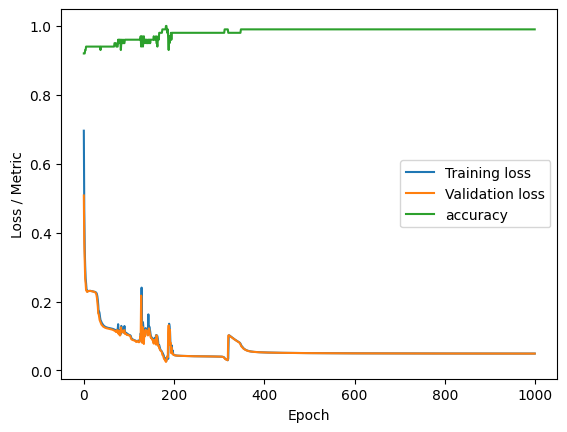

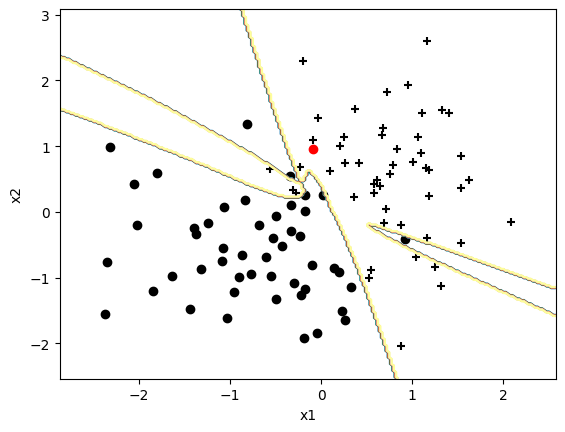

CPU times: user 15.1 s, sys: 39 ms, total: 15.2 s
Wall time: 15.3 s


In [27]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 1234
np.random.seed(seed) if seed else None

# Generate training data
x_trn, d_trn = syn2(100)

# General standardization of input data
mu, std = standard(x_trn)
x_trn = (x_trn - mu) / std

# Define the network, cost function and training settings
model_ex3 = Network(
    inputs=x_trn.shape[1],      # number of input nodes
    outputs=1,                  # number of output nodes
    nodes=[64,32,16,8],                 # number of nodes in hidden layer
    activation=nn.Tanh,         # activation function in hidden layer
    out_activation=nn.Sigmoid   # activation function in output layer
    ).to(device)                # move data to GPU or keep with CPU

# Optimization parameters
opt_method = torch.optim.Adam    # minimization method
learning_rate = 0.01             # learning rate
loss_fn = nn.BCELoss()          # loss function, binary cross entropy
number_epochs = 1000
minibatch_size = 32

# Additional metrics to print
metrics = { 'accuracy': torchmetrics.Accuracy('binary') }

# Print a summary of the model
print(model_ex3)

# Set up the optimizer
optimizer = opt_method(model_ex3.parameters(), lr=learning_rate)

# Turn the training data into a dataset with Tensors on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))

# Create a batch loader for the training data
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size)

# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex3,
    train_dataloader=dl_trn,
    val_dataloader=dl_trn, # Test with the training data
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=100,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Predict output on the training data
d_pred = model_ex3.predict(x_trn)

# Plot the decision boundary
decision_boundary(x_trn, d_trn, model_ex3)

# The report!

We have added intructions inside this report template. As you write your report, remove these instructions.

## Your name

## Introduction
A few sentences about the overall theme of the exercise.

## Answers to questions
Provide enough information to clarify the meaning of your answers, so that they can be understood by someone who does not scroll up and read the entire instruction.

The questions are repeated here, for clarity of what is demanded. If it does not fit your style to quote them verbatim, change the format.

**Question 1**, variations in pre-defined MLP  
**(a)** Do you see the same loss vs epoch behavior each time your run? If not, why?  
**(b)** Do you observe that training fails, i.e. do not reach low loss, during any of these five runs?

**Question 2**, vary learning rate  
Present your average MSE results and discuss your findings.

**Question 3**, vary (mini)batch size  
Present and discuss your findings.

**Question 4**, select good hyper-parameters  
Present your best combination of learning rate and batch size, and its result.

**Question 5**, vary epochs  
Compare the number of epochs needed to reach a good solution with that of Q4.  

Note: If you cannot find a good solution in a reasonable number of epochs, you can "revert" the problem: optimize learning rate and batch size for Q5, and the see how those hyper-parameters perform on Q4.

**Question 6**, vary network size and other hyper-parameters  
Present your set of good hyper-parameters and the result.

Note: If you cannot solve this task in *reasonable* time, present your best attempt!

**Question 7**, optimize hyper-parameters for classification  
Present your set of hyper-parameters that reach > 95% accuracy

**Question 8**, change learning algorithm  
Try the Adam optimizer for Q7, and compare (qualitatively) the results and the number of epochs needed to get them. Present changes you needed to make to improve the results of the Adam optimizer, if any.

**Bonus tasks** (if you feel inspired)

## Summary
Connect the summary to your introduction, to provide a brief overview of your findings.
  

In [ ]:
token =